### Import Necessary Libraries

In [ ]:
!pip install mlflow #xgboost tensorflow sklearn pandas numpy
!pip install keras_tuner
!pip install pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import numpy as np
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import mlflow
import mlflow.sklearn
import mlflow.keras
from mlflow.models.signature import infer_signature
import shap

from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import Booster

from pyngrok import ngrok
import subprocess
import time

import pickle
import os

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

import warnings
warnings.filterwarnings('ignore')

## Data Extraction

We will extract data for primary stock = PepsiCo (PEP), Competitor stock = Coca-Cola (KO), and the market indexS&P 500 (^GSPC) for the past 4 years.


In [ ]:
end = datetime.now() #(2024, 12, 2)
start = datetime(end.year - 4, end.month, end.day)

# Define the stock tickers
primary_stock = 'PEP'  # PepsiCo
competitor_stock = 'KO'  # Coca-Cola

bench_mark_index = '^GSPC' #S&P 500

In [ ]:
pep_data = yf.download(primary_stock, start, end)

pep_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,PEP,PEP,PEP,PEP,PEP
Date,,,,,
2021-04-19,128.912476,129.669480,127.585496,128.680928,6621200
2021-04-20,129.767426,130.604566,128.182168,128.360297,4999700
2021-04-21,130.898453,131.628741,130.212711,131.227979,6316000
2021-04-22,130.088043,130.604572,129.473536,130.239441,4904400
2021-04-23,129.874283,130.328477,129.188527,129.589289,4354700


In [ ]:
co_data = yf.download(competitor_stock, start, end)

co_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,KO,KO,KO,KO,KO
Date,,,,,
2021-04-19,47.874287,48.193449,47.253693,47.874287,19352900
2021-04-20,48.025005,48.397363,47.705846,47.732442,14419200
2021-04-21,48.415096,48.530350,48.087070,48.087070,13866500
2021-04-22,48.264370,48.645591,48.157984,48.290969,12558900
2021-04-23,48.290977,48.397364,48.025006,48.228918,9020500


In [ ]:
index_data = yf.download(bench_mark_index, start, end)

index_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2021-04-19,4163.259766,4180.810059,4150.470215,4179.799805,3810290000
2021-04-20,4134.939941,4159.180176,4118.379883,4159.180176,4342650000
2021-04-21,4173.419922,4175.020020,4126.350098,4128.419922,3887250000
2021-04-22,4134.979980,4179.569824,4123.689941,4170.459961,4245140000
2021-04-23,4180.169922,4194.169922,4138.779785,4138.779785,3569880000


Create adjClose Feature from CLose Column

In [ ]:
# Feature Engineering Function
def add_adjclose(adjclose):
    # Adj Close
    adjclose['Adj Close'] = adjclose['Close']

# Apply the function
add_adjclose(pep_data)
add_adjclose(co_data)
add_adjclose(index_data)

In [ ]:
pep_data.head(2)

Price,Close,High,Low,Open,Volume,Adj Close
Ticker,PEP,PEP,PEP,PEP,PEP,
Date,,,,,,
2021-04-19,128.912476,129.669480,127.585496,128.680928,6621200,128.912476
2021-04-20,129.767426,130.604566,128.182168,128.360297,4999700,129.767426


In [ ]:
co_data.head(2)

Price,Close,High,Low,Open,Volume,Adj Close
Ticker,KO,KO,KO,KO,KO,
Date,,,,,,
2021-04-19,47.874287,48.193449,47.253693,47.874287,19352900,47.874287
2021-04-20,48.025005,48.397363,47.705846,47.732442,14419200,48.025005


In [ ]:
index_data.head(2)

Price,Close,High,Low,Open,Volume,Adj Close
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,
Date,,,,,,
2021-04-19,4163.259766,4180.810059,4150.470215,4179.799805,3810290000,4163.259766
2021-04-20,4134.939941,4159.180176,4118.379883,4159.180176,4342650000,4134.939941


## Feature Engineering
Adding features such as ,  (next day's adjusted close price), and  (binary indicator for price movement direction).

In [ ]:
# Feature Engineering Function
def add_features(data):
    # Daily Return
    data['Daily Return'] = data['Adj Close'].pct_change()
    # Tomorrow's Price
    data['Tomorrow'] = data['Adj Close'].shift(-1)
    # Stock Direction (1 = Price went up, 0 = Price went down)
    data['Stock Direction'] = (data['Tomorrow'] > data['Adj Close']).astype(int)

# Apply the function
add_features(pep_data)
add_features(co_data)
add_features(index_data)

### Preview the updated data

In [ ]:
pep_data.head(2)

Price,Close,High,Low,Open,Volume,Adj Close,Daily Return,Tomorrow,Stock Direction
Ticker,PEP,PEP,PEP,PEP,PEP,,,,
Date,,,,,,,,,
2021-04-19,128.912476,129.669480,127.585496,128.680928,6621200,128.912476,NaN,129.767426,1
2021-04-20,129.767426,130.604566,128.182168,128.360297,4999700,129.767426,0.006632,130.898453,1


In [ ]:
co_data.head(2)

Price,Close,High,Low,Open,Volume,Adj Close,Daily Return,Tomorrow,Stock Direction
Ticker,KO,KO,KO,KO,KO,,,,
Date,,,,,,,,,
2021-04-19,47.874287,48.193449,47.253693,47.874287,19352900,47.874287,NaN,48.025005,1
2021-04-20,48.025005,48.397363,47.705846,47.732442,14419200,48.025005,0.003148,48.415096,1


In [ ]:
index_data.head(2)

Price,Close,High,Low,Open,Volume,Adj Close,Daily Return,Tomorrow,Stock Direction
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,,,,
Date,,,,,,,,,
2021-04-19,4163.259766,4180.810059,4150.470215,4179.799805,3810290000,4163.259766,NaN,4134.939941,0
2021-04-20,4134.939941,4159.180176,4118.379883,4159.180176,4342650000,4134.939941,-0.006802,4173.419922,1


## Exploratory Data Analysis

Investigate historical trends, returns, and volatility for each stock.

### 1. Historical Trends
Visualizing the Adjusted Close prices over time.

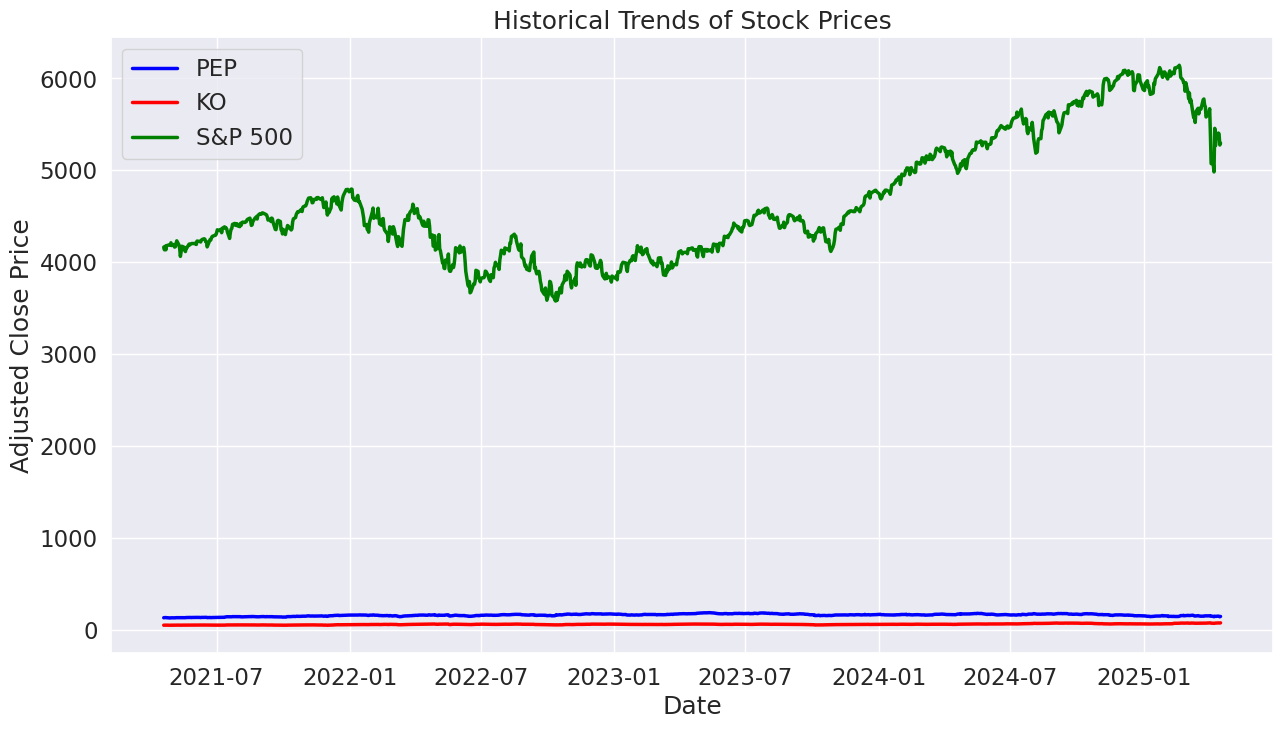

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(pep_data['Adj Close'], label='PEP', color='blue')
plt.plot(co_data['Adj Close'], label='KO', color='red')
plt.plot(index_data['Adj Close'], label='S&P 500', color='green')
plt.title('Historical Trends of Stock Prices')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
#plt.grid(True)
plt.show()

Daily Returns overtime

In [ ]:
# Add daily returns to a single DataFrame for visualization
pep_data['Type'] = 'PEP'
co_data['Type'] = 'KO'
index_data['Type'] = 'S&P 500'

# Reset index to make 'Date' a column
pep_data = pep_data.reset_index()
co_data = co_data.reset_index()
index_data = index_data.reset_index()

daily_returns = pd.concat([pep_data[['Date', 'Daily Return', 'Type']],
                           co_data[['Date', 'Daily Return', 'Type']],
                           index_data[['Date', 'Daily Return', 'Type']]])

In [ ]:
print(type(daily_returns.columns))
print(daily_returns.columns)

<class 'pandas.core.indexes.multi.MultiIndex'>
MultiIndex([(        'Date', ''),
            ('Daily Return', ''),
            (        'Type', '')],
           names=['Price', 'Ticker'])


In [ ]:
daily_returns.columns = ['Date', 'Daily Return', 'Type']

In [ ]:
# Create an interactive line plot
fig_returns = px.line(
    daily_returns,
    x='Date',
    y='Daily Return',
    color='Type',
    title='Daily Return Trends Over Time',
    labels={'Daily Return': 'Daily Return', 'Date': 'Date'}
)
fig_returns.show()

Cummulative Returns

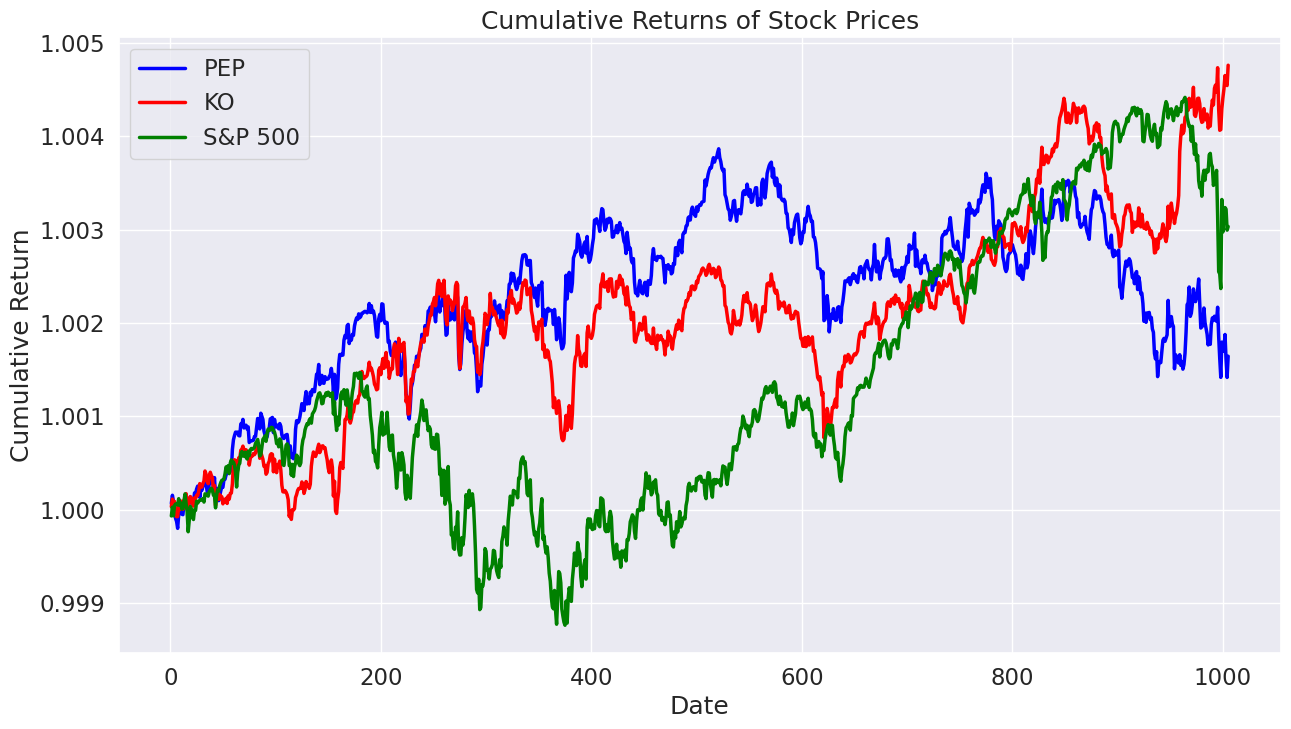

In [ ]:
pep_data['Cumulative Return'] = (1 + pep_data['Daily Return'] / 100).cumprod()
co_data['Cumulative Return'] = (1 + co_data['Daily Return'] / 100).cumprod()
index_data['Cumulative Return'] = (1 + index_data['Daily Return'] / 100).cumprod()

plt.figure(figsize=(15, 8))
plt.plot(pep_data['Cumulative Return'], label='PEP', color='blue')
plt.plot(co_data['Cumulative Return'], label='KO', color='red')
plt.plot(index_data['Cumulative Return'], label='S&P 500', color='green')

plt.title('Cumulative Returns of Stock Prices')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

### Volatility Analysis
Analyzing the distributions of daily returns.

In [ ]:
pep_volatility = pep_data['Daily Return'].std()
co_volatility = co_data['Daily Return'].std()
index_volatility = index_data['Daily Return'].std()

print(f"Volatility of PEP: {pep_volatility}")
print(f"Volatility of KO: {co_volatility}")
print(f"Volatility of S&P 500: {index_volatility}")

Volatility of PEP: 0.010842520478917613
Volatility of KO: 0.010003347979381502
Volatility of S&P 500: 0.011187179807819485


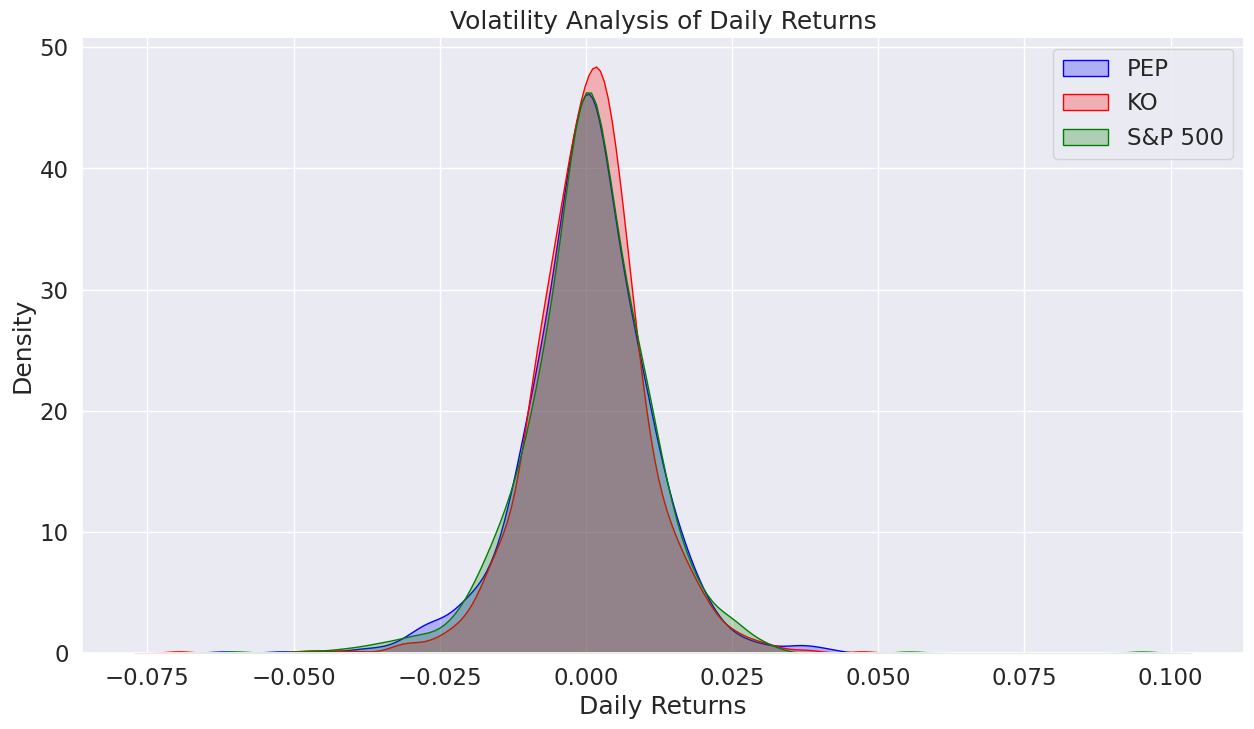

In [ ]:
plt.figure(figsize=(15, 8))

sns.kdeplot(pep_data['Daily Return'].dropna(), label='PEP', fill=True, color='blue')
sns.kdeplot(co_data['Daily Return'].dropna(), label='KO', fill=True, color='red')
sns.kdeplot(index_data['Daily Return'].dropna(), label='S&P 500', fill=True, color='green')

plt.title('Volatility Analysis of Daily Returns')
plt.xlabel('Daily Returns')
plt.legend()
# plt.grid(True)
plt.show()

KDE plots provide a smooth curve that makes it easier to identify the concentration and spread of returns.

A wider curve means more volatility (more extreme returns), while a narrower curve suggests less volatility

A narrower distribution (concentrated around zero) suggests lower volatility.

A wider distribution indicates higher volatility.

### 2. Dynamic Visualizations

Showcasing pricing trends and highlight sector impacts.

### Dynamic Pricing Trends
Visualizing trends with overlapping time series.

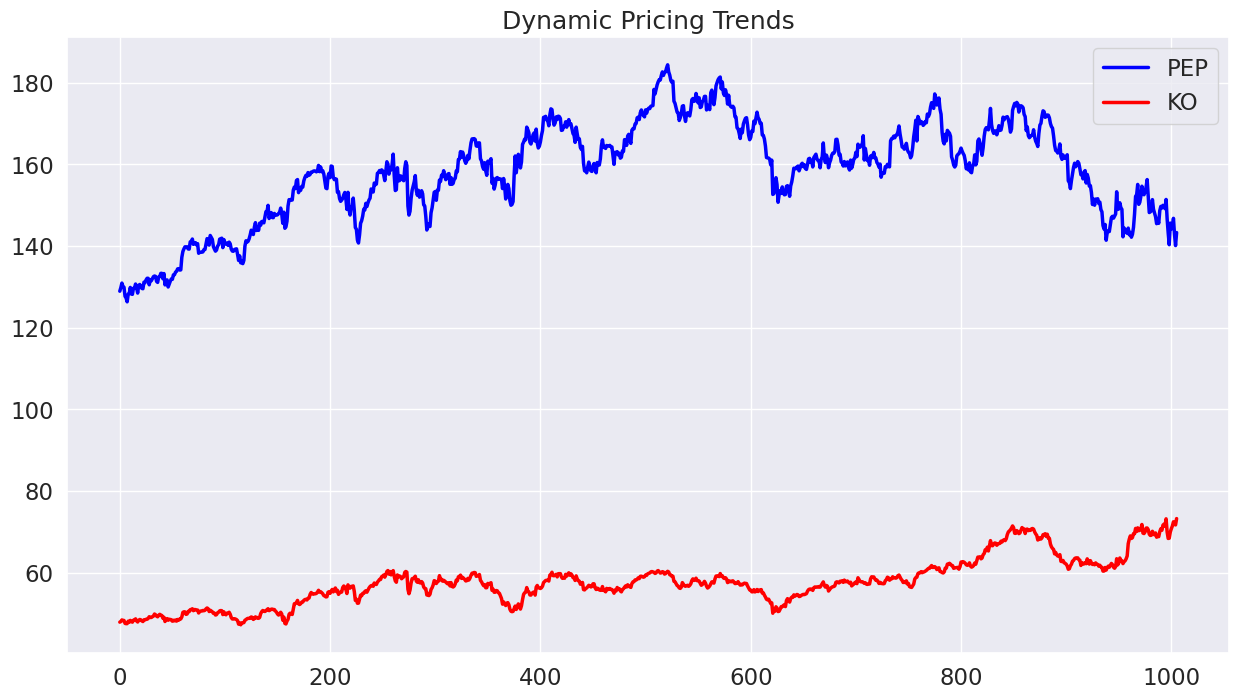

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(pep_data['Adj Close'], label='PEP', color='blue')
plt.plot(co_data['Adj Close'], label='KO', color='red')
plt.title('Dynamic Pricing Trends')
plt.legend()
#plt.grid(True)
plt.show()

### 3. Comparative Analysis
### Correlation Analysis:
Evaluating relationships between each stock and the benchmark index.

In [ ]:
primary_vs_benchmark_corr = pep_data['Adj Close'].corr(index_data['Adj Close'])
competitor_vs_benchmark_corr = co_data['Adj Close'].corr(index_data['Adj Close'])

print(f"Correlation Between PEP and S&P 500: {primary_vs_benchmark_corr}")
print(f"Correlation Between KO and S&P 500: {competitor_vs_benchmark_corr}")

Correlation Between PEP and S&P 500: 0.04684633510547208
Correlation Between KO and S&P 500: 0.6604477803202021


In [ ]:
# Calculated correlation values
correlations = pd.DataFrame({
    'Stock': ['PEP', 'KO'],
    'Correlation with S&P 500': [
        pep_data['Adj Close'].corr(index_data['Adj Close']),
        co_data['Adj Close'].corr(index_data['Adj Close'])
    ]
})

# Create a bar plot
fig_corr = px.bar(
    correlations,
    x='Stock',
    y='Correlation with S&P 500',
    title='Correlation with S&P 500',
    text='Correlation with S&P 500',
    labels={'Correlation with S&P 500': 'Correlation Coefficient'}
)
fig_corr.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig_corr.show()

### Observation
Comparative Insights:

The results from correlation and volatility analysis provide insights into the suitability of each stock for investment relative to market performance.

PEP has a moderate positive correlation, meaning PEP moves somewhat with the market but also has independent movements.

Ko has a stronger positive correlation, meaning KO tends to follow the movements of the S&P 500 more closely than PEP.

It is more likely to be affected by market-wide events. If the market performs well, KO could benefit more than PEP But if the market crashes, KO might suffer more compared to PEP.

Since PEP has a lower correlation with the market, it could be a better hedge against broader market downturns compared to KO.

If an investor wants stability and lower dependency on the S&P 500, PEP might be a better choice.


### 4. Comparative Volatility Analysis:
Computing the standard deviation of daily returns to assess risk levels.

In [ ]:
primary_volatility = pep_data['Daily Return'].std()
competitor_volatility = co_data['Daily Return'].std()
benchmark_volatility = index_data['Daily Return'].std()

print(f"PEP Daily Return Volatility: {primary_volatility}")
print(f"KO Daily Return Volatility: {competitor_volatility}")
print(f"S&P 500 Daily Return Volatility: {benchmark_volatility}")

PEP Daily Return Volatility: 0.010842520478917613
KO Daily Return Volatility: 0.010003347979381502
S&P 500 Daily Return Volatility: 0.011187179807819485


In [ ]:
# Calculated volatility values
volatility = pd.DataFrame({
    'Stock': ['PEP', 'KO', 'S&P 500'],
    'Volatility': [
        pep_data['Daily Return'].std(),
        co_data['Daily Return'].std(),
        index_data['Daily Return'].std()
    ]
})

# Create a bar plot
fig_volatility = px.bar(
    volatility,
    x='Stock',
    y='Volatility',
    title='Daily Return Volatility',
    text='Volatility',
    labels={'Volatility': 'Standard Deviation'}
)
fig_volatility.update_traces(texttemplate='%{text:.4f}', textposition='outside')
fig_volatility.show()

### Observation

PepsiCo’s daily returns fluctuate a little more than Coca-Cola’s. This means PEP has a slightly higher risk in terms of daily price movements.

KO has the lowest daily return volatility of the three, meaning it tends to experience smaller price swings compared to PEP and the S&P 500. This could make KO a more stable stock, which might appeal to risk-averse investors.

Since PEP’s volatility (1.03%) is almost the same as the S&P 500’s, it means PEP moves with the overall market in terms of risk. KO, on the other hand, has lower volatility than both, making it a relatively safer bet in the short term.

If they are willing to take on more risk for potential higher returns, PEP might be the better choice.

In [ ]:
# Compute average returns
volatility_returns = pd.DataFrame({
    'Stock': ['PEP', 'KO', 'S&P 500'],
    'Volatility': [
        pep_data['Daily Return'].std(),
        co_data['Daily Return'].std(),
        index_data['Daily Return'].std()
    ],
    'Avg Return': [
        pep_data['Daily Return'].mean(),
        co_data['Daily Return'].mean(),
        index_data['Daily Return'].mean()
    ]
})

# Create a scatter plot
fig_vol_returns = px.scatter(
    volatility_returns,
    x='Volatility',
    y='Avg Return',
    color='Stock',
    size='Volatility',
    hover_name='Stock',
    title='Volatility vs. Average Daily Return',
    labels={'Volatility': 'Volatility (Standard Deviation)', 'Avg Return': 'Average Return'}
)
fig_vol_returns.show()

### Observation

The S&P 500 has both high returns and moderate volatility, making it a better investment option than PEP or KO in terms of risk-adjusted returns.

KO seems safer due to lower volatility, but its lower return might not be appealing to aggressive investors.

Risk-adjusted returns (Sharpe Ratio) to see which stock gives better returns for the risk taken

In [ ]:
# Assume risk-free rate (R_f) is 0 for simplicity
risk_free_rate = 0

# Compute average daily returns
pep_avg_return = pep_data['Daily Return'].mean()
ko_avg_return = co_data['Daily Return'].mean()

# Compute standard deviation of daily returns (volatility)
pep_volatility = pep_data['Daily Return'].std()
ko_volatility = co_data['Daily Return'].std()

# Compute Sharpe Ratios
pep_sharpe_ratio = (pep_avg_return - risk_free_rate) / pep_volatility
ko_sharpe_ratio = (ko_avg_return - risk_free_rate) / ko_volatility

# Print Results
print(f"PEP Sharpe Ratio: {pep_sharpe_ratio:.2f}")
print(f"KO Sharpe Ratio: {ko_sharpe_ratio:.2f}")

# Visualize the Sharpe Ratios
sharpe_ratios = pd.DataFrame({
    'Stock': ['PEP', 'KO'],
    'Sharpe Ratio': [pep_sharpe_ratio, ko_sharpe_ratio]
})

fig_sharpe = px.bar(
    sharpe_ratios,
    x='Stock',
    y='Sharpe Ratio',
    title='Sharpe Ratio Comparison (Risk-Adjusted Returns)',
    text='Sharpe Ratio',
    labels={'Sharpe Ratio': 'Sharpe Ratio'}
)

fig_sharpe.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig_sharpe.show()


PEP Sharpe Ratio: 0.02
KO Sharpe Ratio: 0.05


Both stocks from Sharpe Ratios, suggesting relatively low risk-adjusted returns

KO outperforms PEP when adjustinf for risk, meaning it might be a better option for investors looking for a balance of returns vs. volatility

In [ ]:
# Compute S&P 500 average daily return and volatility
sp500_avg_return = index_data['Daily Return'].mean()
sp500_volatility = index_data['Daily Return'].std()

# Compute Sharpe Ratio for S&P 500
sp500_sharpe_ratio = (sp500_avg_return - risk_free_rate) / sp500_volatility

# Print Results
print(f"S&P 500 Sharpe Ratio: {sp500_sharpe_ratio:.2f}")

# Visualize all three Sharpe Ratios
sharpe_ratios = pd.DataFrame({
    'Stock': ['PEP', 'KO', 'S&P 500'],
    'Sharpe Ratio': [pep_sharpe_ratio, ko_sharpe_ratio, sp500_sharpe_ratio]
})

fig_sharpe = px.bar(
    sharpe_ratios,
    x='Stock',
    y='Sharpe Ratio',
    title='Sharpe Ratio Comparison (PEP vs KO vs S&P 500)',
    text='Sharpe Ratio',
    labels={'Sharpe Ratio': 'Sharpe Ratio'}
)

fig_sharpe.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig_sharpe.show()

S&P 500 Sharpe Ratio: 0.03


## Analysis Insights/

### Observations

1. Historical Trends:
- The Adjusted Close prices of PepsiCo (PEP), Coca-Cola (KO), and the S&P 500 index (^GSPC) exhibit a steady upward trend over the last four years, indicating overall market growth during this period.
-There are instances of dips in stock prices, likely corresponding to external economic events or company-specific challenges

2. Volatility:
- PEP shows relatively lower volatility compared to KO and S&P 500, which suggests it may be a less risky investment option.
- KO exhibits moderate volatility, implying a balance between risk and reward.
- The S&P 500 index demonstrates the highest volatility, reflecting its broader exposure to market fluctuations and external shocks.

3. Daily Returns:
- The distribution of daily returns for all three shows typical behavior: a central concentration near zero and some sporadic spikes. PEP’s daily returns distribution is narrower than KO’s, indicating more consistent performance.

4. Correlation Analysis:
- Both PEP and KO have positive correlations with the S&P 500, with PEP slightly stronger. This suggests their performance aligns reasonably well with overall market trends.
- The correlation insights imply that PEP is slightly more in sync with market benchmarks than KO, which is beneficial for predicting future behaviors.

5. Volatility vs. Returns:
- PEP’s lower volatility comes with relatively steady returns, indicating it as a stable option for long-term investments.
- KO’s higher volatility might attract investors looking for a slightly more aggressive strategy, but its average returns are similar to PEP.
- The S&P 500 offers broader exposure but carries significant volatility, suggesting it’s better suited for diversified portfolios

6. Stock Directions:
- The direction analysis highlights that KO has more instances of upward price movement compared to PEP, which may indicate better market confidence in PEP's performance.



### Key insights
 The insights derived include;
-  Performance vs. Risk Trade-Off

For the both stocks (KO and PEP) KO has the next highest average return with lower volatility, making it a more stable choice.

PEP has high volatility but a low average return, which is not ideal because it suggests more risk without enough reward.

*Implication:*  KO is a better-performing stock compared to PEP, while the S&P 500 provides the highest returns but requires higher risk tolerance.


- Market Sensitivity (Correlation with S&P 500)

KO (0.64 correlation) moves more closely with the S&P 500, meaning it follows overall market trends more consistently.

PEP (0.38 correlation) moves more independently, meaning its price swings are more influenced by company-specific factors rather than the overall market.

*Implication:*

KO is a better choice for those who want a stock that aligns with broader market trends.


## Recommendations

1. Investment Strategy:
- For risk-averse investors, Coca-Cola (KO) appears to be the better option due to its lower volatility and stable upward price trend.
- PEPSICO (PEP), with its higher volatility, may appeal to those looking for moderate-risk investments with comparable returns.

    ####  Investment Decision Perspective
    Best for Growth: S&P 500 (highest average return, but also high volatility).

    Best for Stability: KO (steady returns, lower volatility, and moves with the market).

    Most Uncertain/Risky: PEP (high volatility but low average returns, meaning risk is not well compensated).


2. Portfolio Diversification:
Including the S&P 500 index (^GSPC) in the portfolio can add diversification and broader market exposure, though investors should be prepared to handle greater volatility.

    #### For building a portfolio:
    - S&P 500 → Best for long-term growth (if you can tolerate volatility).

    - KO → Good for steady returns with less risk.

    - PEP → Might need further investigation since it’s volatile but not offering strong returns.


3. Monitor Market Conditions:
- Regularly track external factors such as economic events, sector trends, and company-specific updates to align investment decisions with prevailing market conditions.

4. Focus on Stability:
- For long-term investment goals, prioritize stocks with lower volatility and consistent returns, such as PepsiCo.


## Conclusion
The exploratory data analysis provides valuable insights into the performance, volatility, and correlation of PepsiCo, Coca-Cola, and the S&P 500 index over the past four years. PEP stands out as a stable investment option with steady returns and less volatility, while KO offers slightly more risk for similar average returns. The S&P 500 index provides exposure to broader market trends but carries higher risk.
Investors should consider these factors alongside their financial goals and risk appetite. By balancing stability, growth potential, and market exposure, a diversified portfolio can be constructed to optimize returns while minimizing risk. Regular monitoring and analysis are essential for adapting to market fluctuations and ensuring alignment with investment strategies.


## **Modeling and Evaluation**
Modeling and evaluation for predicting stock price movement (stock’s direction).

The entire workflow using XGBoost, LSTM, model fine-tuning, validation, performance evaluation, and tracking with MLflow.


Metrics like accuracy, F1-score, and confusion matrices will be used to compare models.

### Feature Engineering

In [ ]:
# Function to calculate technical indicators and add target variable
def add_indicators(df):
    # Simple Moving Average (SMA)
    df['SMA_20'] = df['Adj Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Adj Close'].rolling(window=50).mean()

    # Exponential Moving Average (EMA)
    df['EMA_20'] = df['Adj Close'].ewm(span=20, adjust=False).mean()
    df['EMA_50'] = df['Adj Close'].ewm(span=50, adjust=False).mean()

    # Relative Strength Index (RSI)
    delta = df['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    short_ema = df['Adj Close'].ewm(span=12, adjust=False).mean()
    long_ema = df['Adj Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = short_ema - long_ema
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Volatility
    df['Volatility'] = df['Daily Return'].rolling(window=20).std()

    # Bollinger Bands (Upper & Lower Bands)
    df['Middle_Band'] = df['Adj Close'].rolling(window=20).mean()
    df['Std_Dev'] = df['Adj Close'].rolling(window=20).std()
    df['Upper_Band'] = df['Middle_Band'] + (2 * df['Std_Dev'])
    df['Lower_Band'] = df['Middle_Band'] - (2 * df['Std_Dev'])


    return df.dropna(inplace=True)

In [ ]:
# Apply indicators to all data
for df in [pep_data, co_data, index_data]:
    add_indicators(df)

In [ ]:
pep_data.head()

Price,Date,Close,High,Low,Open,Volume,Adj Close,Daily Return,Tomorrow,Stock Direction,...,EMA_20,EMA_50,RSI,MACD,Signal_Line,Volatility,Middle_Band,Std_Dev,Upper_Band,Lower_Band
Ticker,,PEP,PEP,PEP,PEP,PEP,,,,,...,,,,,,,,,,
49,2021-06-28,131.908569,132.401973,131.531792,131.657384,4282800,131.908569,0.004303,131.818909,0,...,131.507427,130.862956,52.354115,0.124996,0.315541,0.007972,131.882782,0.937131,133.757044,130.008520
50,2021-06-29,131.818909,132.500695,131.334471,132.276421,3197700,131.818909,-0.000680,132.922318,1,...,131.537092,130.900444,52.987162,0.139312,0.280295,0.007958,131.899860,0.932454,133.764769,130.034951
51,2021-06-30,132.922318,133.047910,132.052136,132.258464,4943700,132.922318,0.008371,132.949234,1,...,131.669018,130.979733,52.066715,0.236962,0.271628,0.008127,131.945836,0.960058,133.865951,130.025720
52,2021-07-01,132.949234,133.738681,132.715995,132.841587,3997600,132.949234,0.000202,133.586151,1,...,131.790943,131.056969,51.857216,0.312915,0.279886,0.008093,131.969609,0.979508,133.928626,130.010592
53,2021-07-02,133.586151,134.366618,133.272163,133.577171,3835500,133.586151,0.004791,133.783539,1,...,131.961916,131.156152,51.253625,0.419665,0.307842,0.008156,132.017603,1.035304,134.088210,129.946995


In [ ]:
co_data.head()

Price,Date,Close,High,Low,Open,Volume,Adj Close,Daily Return,Tomorrow,Stock Direction,...,EMA_20,EMA_50,RSI,MACD,Signal_Line,Volatility,Middle_Band,Std_Dev,Upper_Band,Lower_Band
Ticker,,KO,KO,KO,KO,KO,,,,,...,,,,,,,,,,
49,2021-06-28,48.467270,48.565527,48.235029,48.458339,10556900,48.467270,-0.001105,48.109970,0,...,48.794734,48.629424,40.268955,-0.061615,0.062087,0.007926,49.061562,0.531364,50.124291,47.998834
50,2021-06-29,48.109970,48.538725,47.984917,48.351146,12300900,48.109970,-0.007372,48.333279,1,...,48.729519,48.609054,38.489903,-0.105978,0.028474,0.008071,49.016607,0.572481,50.161569,47.871644
51,2021-06-30,48.333279,48.395805,48.011711,48.056373,14614200,48.333279,0.004642,48.199291,0,...,48.691782,48.598239,36.340234,-0.121714,-0.001564,0.008094,48.973063,0.590308,50.153680,47.792447
52,2021-07-01,48.199291,48.663777,48.109968,48.538724,13214700,48.199291,-0.002772,48.395809,1,...,48.644878,48.582594,32.056634,-0.143344,-0.029920,0.008064,48.916616,0.608261,50.133138,47.700093
53,2021-07-02,48.395809,48.636985,48.235025,48.235025,10604600,48.395809,0.004077,48.127842,0,...,48.621157,48.575269,36.272670,-0.142980,-0.052532,0.007672,48.843397,0.575982,49.995360,47.691433


In [ ]:
co_data.head().T

,,49,50,51,52,53
Price,Ticker,,,,,
Date,,2021-06-28 00:00:00,2021-06-29 00:00:00,2021-06-30 00:00:00,2021-07-01 00:00:00,2021-07-02 00:00:00
Close,KO,48.46727,48.10997,48.333279,48.199291,48.395809
High,KO,48.565527,48.538725,48.395805,48.663777,48.636985
Low,KO,48.235029,47.984917,48.011711,48.109968,48.235025
Open,KO,48.458339,48.351146,48.056373,48.538724,48.235025
Volume,KO,10556900,12300900,14614200,13214700,10604600
Adj Close,,48.46727,48.10997,48.333279,48.199291,48.395809
Daily Return,,-0.001105,-0.007372,0.004642,-0.002772,0.004077
Tomorrow,,48.10997,48.333279,48.199291,48.395809,48.127842


### Select Feature Columns needed

In [ ]:
# Define the feature columns and target column
feature_columns = ['High','Volume', 'Adj Close', 'Daily Return', 'Tomorrow', 'Cumulative Return',	'SMA_20', 'EMA_20', 'RSI', 'MACD', 'Signal_Line', 'Volatility', 'Middle_Band', 'Std_Dev']

target_column = 'Stock Direction'

# Function to prepare data for machine learning without dropping NaN rows
def prepare_ml_data(stock_df):
    # Directly select the features and target column
    X = stock_df[feature_columns]
    y = stock_df['Stock Direction']
    # Train-test split (80:20) with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
    )
    return X_train, X_test, y_train, y_test

### Feature Sets

In [ ]:
# Prepare data for each stock
X_train_pep, X_test_pep, y_train_pep, y_test_pep = prepare_ml_data(pep_data)
X_train_ko, X_test_ko, y_train_ko, y_test_ko = prepare_ml_data(co_data)

In [ ]:
# Normalize features using MinMaxScaler
scaler_pep = MinMaxScaler()
X_train_pep_norm = scaler_pep.fit_transform(X_train_pep)
X_test_pep_norm = scaler_pep.transform(X_test_pep)

scaler_ko = MinMaxScaler()
X_train_ko_norm = scaler_ko.fit_transform(X_train_ko)
X_test_ko_norm = scaler_ko.transform(X_test_ko)

In [ ]:
# Get the majority classes for baseline comparison
majority_class_pep = y_train_pep.mode()[0]
majority_class_ko = y_train_ko.mode()[0]

In [ ]:
# Set up MLflow tracking
mlflow.set_tracking_uri("http://127.0.0.1:5000")

### Set Create Experiment Locally or via ngrok

#### Locally

In [ ]:
# Set/Create an MLflow experiment;
mlflow.set_tracking_uri("file:///tmp/mlruns")  # Local directory
mlflow.set_experiment("Stock_Direction_Prediction")

2025/04/17 19:45:02 INFO mlflow.tracking.fluent: Experiment with name 'Stock_Direction_Prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///tmp/mlruns/994734341735529191', creation_time=1744919102645, experiment_id='994734341735529191', last_update_time=1744919102645, lifecycle_stage='active', name='Stock_Direction_Prediction', tags={}>

In [ ]:
# Set/Create an MLflow experiment;
#mlflow.set_tracking_uri("/content/drive/MyDrive/Colab Notebooks/Amdari_Work_Exp_Internship_Cohort/StockMarketTrendAnalysis")
#mlflow.set_experiment("Stock_Direction_Prediction")

#### Ngrok

# input your authotoken here, and remove all Hashtags

In [ ]:
#!ngrok input yout authotoken here, and remove all Hashtags

In [ ]:
# Open an ngrok tunnel to the MLflow tracking server port (5000)
#public_url = ngrok.connect(5000)
#print("MLflow UI available at:", public_url)

# Launch the MLflow server in the background
# Here we specify a local sqlite DB to track experiments and a directory for artifact storage.
#mlflow_server_cmd = (
    #"mlflow server --backend-store-uri sqlite:///mlflow.db "
    #"--default-artifact-root ./mlruns --host 0.0.0.0 --port 5000"
#)
# Start the MLflow server as a background process
#process = subprocess.Popen(mlflow_server_cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Give the server a moment to start up
#time.sleep(5)

# Configure MLflow to use the public URL provided by ngrok
# Get the public URL as a string
#mlflow.set_tracking_uri(public_url.public_url)  # Use public_url.public_url to get the URL string

#mlflow.set_experiment("Stock_Direction_Prediction")

## Train XGBoost Model

In [ ]:
# Enable MLflow autologging for XGBoost models
mlflow.xgboost.autolog()

In [ ]:
# Optional: helper to flatten MultiIndex columns if necessary
def flatten_columns(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df

# Ensure training and testing sets have a simple, flat column index
X_train_pep = flatten_columns(X_train_pep)
X_test_pep = flatten_columns(X_test_pep)

# Initialize the model
model_pep_xgb = XGBClassifier()

with mlflow.start_run(run_name="XGB_PEP_Model"):
    # Train the model
    model_pep_xgb.fit(X_train_pep, y_train_pep)

    # Generate predictions and compute accuracy
    y_pred_pep = model_pep_xgb.predict(X_test_pep)
    accuracy_pep_xgb = accuracy_score(y_test_pep, y_pred_pep)
    mlflow.log_metric("accuracy", accuracy_pep_xgb)

    # Baseline comparison (predict the majority class)
    baseline_preds_pep = np.full_like(y_test_pep, fill_value=majority_class_pep)
    baseline_accuracy_pep = accuracy_score(y_test_pep, baseline_preds_pep)
    mlflow.log_metric("baseline_accuracy", baseline_accuracy_pep)

    # Log classification report as an artifact
    report_pep = classification_report(y_test_pep, y_pred_pep)
    with open("classification_report_pep.txt", "w") as f:
        f.write(report_pep)
    mlflow.log_artifact("classification_report_pep.txt")

    # Infer the model signature from training data
    signature = infer_signature(X_train_pep, y_train_pep)

    # Prepare an input example by resetting the index
    input_example = X_train_pep.iloc[:1].reset_index(drop=True)

    # Log the model with signature and input example
    mlflow.sklearn.log_model(
        sk_model=model_pep_xgb,
        artifact_path="xgb_pep_model",
        signature=signature,
        input_example=input_example
    )

    print(f"XGB PEP Model | Accuracy: {accuracy_pep_xgb:.4f} | Baseline Accuracy: {baseline_accuracy_pep:.4f}")

# Save the trained model to a pickle file
pickle_filename = "xgb_pep_model.pkl"
with open(pickle_filename, "wb") as file:
    pickle.dump(model_pep_xgb, file)

# Optionally, log the pickle file as an MLflow artifact
mlflow.log_artifact(pickle_filename)
print(f"Model saved to {pickle_filename}")

XGB PEP Model | Accuracy: 0.8125 | Baseline Accuracy: 0.5208
Model saved to xgb_pep_model.pkl


In [ ]:
# Extract Booster from the trained PEP model
booster_pep = model_pep_xgb.get_booster()

# Save the model using Booster.save_model
booster_pep.save_model("xgb_pep_model.xgb")
print("PEP XGBoost model saved as 'xgb_pep_model.xgb'")

PEP XGBoost model saved as 'xgb_pep_model.xgb'


In [ ]:
mlflow.end_run()

In [ ]:
# XGBOOST for KO
# Optional helper to flatten MultiIndex columns, if needed
def flatten_columns(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df

# Ensure training and testing data have a flat column index
X_train_ko = flatten_columns(X_train_ko)
X_test_ko = flatten_columns(X_test_ko)

model_ko_xgb = XGBClassifier()

with mlflow.start_run(run_name="XGB_KO_Model"):
    # Train the model
    model_ko_xgb.fit(X_train_ko, y_train_ko)

    # Generate predictions and calculate accuracy
    y_pred_ko = model_ko_xgb.predict(X_test_ko)
    accuracy_ko_xgb = accuracy_score(y_test_ko, y_pred_ko)
    mlflow.log_metric("accuracy", accuracy_ko_xgb)

    # Baseline comparison using the majority class
    baseline_preds_ko = np.full_like(y_test_ko, fill_value=majority_class_ko)
    baseline_accuracy_ko = accuracy_score(y_test_ko, baseline_preds_ko)
    mlflow.log_metric("baseline_accuracy", baseline_accuracy_ko)

    # Log the classification report as an artifact
    report_ko = classification_report(y_test_ko, y_pred_ko)
    with open("classification_report_ko.txt", "w") as f:
        f.write(report_ko)
    mlflow.log_artifact("classification_report_ko.txt")

    # Infer the model signature from the training data
    signature = infer_signature(X_train_ko, y_train_ko)

    # Create a clean input example from the training data
    input_example = X_train_ko.iloc[:1].reset_index(drop=True)

    # Log the trained model along with the signature and input example
    mlflow.sklearn.log_model(
        sk_model=model_ko_xgb,
        artifact_path="xgb_ko_model",
        signature=signature,
        input_example=input_example
    )

    print(f"XGB KO Model | Accuracy: {accuracy_ko_xgb:.4f} | Baseline Accuracy: {baseline_accuracy_ko:.4f}")

# Save the trained model to a pickle file
pickle_filename = "xgb_ko_model.pkl"
with open(pickle_filename, "wb") as file:
    pickle.dump(model_ko_xgb, file)

# Optionally, log the pickle file as an MLflow artifact
mlflow.log_artifact(pickle_filename)
print(f"Model saved to {pickle_filename}")

XGB KO Model | Accuracy: 0.7292 | Baseline Accuracy: 0.5417
Model saved to xgb_ko_model.pkl


In [ ]:
# Extract Booster from the trained XGBoost model
booster_ko = model_ko_xgb.get_booster()

# Save the model using Booster.save_model
booster_ko.save_model("xgb_ko_model.xgb")
print("KO XGBoost model saved as 'xgb_ko_model.xgb'")

KO XGBoost model saved as 'xgb_ko_model.xgb'


In [ ]:
mlflow.end_run()

In [ ]:
!ngrok tunnels kill

## Train LSTM Model

In [ ]:
# Enable MLflow autologging for TensorFlow/Keras models.
mlflow.tensorflow.autolog()

In [ ]:
# Recall this

# Normalize features using MinMaxScaler
scaler_pep = MinMaxScaler()
X_train_pep_norm = scaler_pep.fit_transform(X_train_pep)
X_test_pep_norm = scaler_pep.transform(X_test_pep)

scaler_ko = MinMaxScaler()
X_train_ko_norm = scaler_ko.fit_transform(X_train_ko)
X_test_ko_norm = scaler_ko.transform(X_test_ko)

# Get the majority classes for baseline comparison
majority_class_pep = y_train_pep.mode()[0]
majority_class_ko = y_train_ko.mode()[0]

In [ ]:
# Reshape normalized arrays to 3D for LSTM: (samples, timesteps, features)
X_train_pep_lstm = X_train_pep_norm.reshape((X_train_pep_norm.shape[0], X_train_pep_norm.shape[1], 1))
X_test_pep_lstm = X_test_pep_norm.reshape((X_test_pep_norm.shape[0], X_test_pep_norm.shape[1], 1))

X_train_ko_lstm = X_train_ko_norm.reshape((X_train_ko_norm.shape[0], X_train_ko_norm.shape[1], 1))
X_test_ko_lstm = X_test_ko_norm.reshape((X_test_ko_norm.shape[0], X_test_ko_norm.shape[1], 1))

In [ ]:
# --- Callback Definitions ---
# Early stopping and checkpoint for PEP
early_stopping_pep = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_pep = ModelCheckpoint('best_model_pep.keras', save_best_only=True, verbose=1)

# Early stopping and checkpoint for KO
early_stopping_ko = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_ko = ModelCheckpoint('best_model_ko.keras', save_best_only=True, verbose=1)

In [ ]:
# --- LSTM Model Building for PEP ---
lstm_model_pep = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_pep_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])
lstm_model_pep.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# --- Generate Predictions for the Test Set ---
lstm_predictions_prob_pep = lstm_model_pep.predict(X_test_pep_lstm)  # Generate probabilities
lstm_predictions_pep = (lstm_predictions_prob_pep > 0.5).astype(int).flatten()  # Threshold at 0.5 and flatten to 1D

# --- Evaluate the LSTM Model's Performance ---
print("LSTM Performance for PEP:")
accuracy_pep = accuracy_score(y_test_pep, lstm_predictions_pep)
print(f"Accuracy: {accuracy_pep:.2f}")

# Print the classification report
print(classification_report(y_test_pep, lstm_predictions_pep))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  
LSTM Performance for PEP:
Accuracy: 0.52
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        92
           1       0.52      1.00      0.68       100

    accuracy                           0.52       192
   macro avg       0.26      0.50      0.34       192
weighted avg       0.27      0.52      0.36       192



In [ ]:
# --- Log Detailed Evaluation Metrics ---
evaluation_metrics_pep = {
    "accuracy": accuracy_pep,
    "precision": classification_report(y_test_pep, lstm_predictions_pep, output_dict=True)["weighted avg"]["precision"],
    "recall": classification_report(y_test_pep, lstm_predictions_pep, output_dict=True)["weighted avg"]["recall"],
    "f1_score": classification_report(y_test_pep, lstm_predictions_pep, output_dict=True)["weighted avg"]["f1-score"]
}

# Print and log all evaluation metrics
print("Evaluation Metrics for PEP:")
for metric, value in evaluation_metrics_pep.items():
    print(f"{metric.capitalize()}: {value:.2f}")

Evaluation Metrics for PEP:
Accuracy: 0.52
Precision: 0.27
Recall: 0.52
F1_score: 0.36


In [ ]:
#Optional: Save metrics for further analysis or tracking
metrics_path = "evaluation_metrics_pep.txt"
with open(metrics_path, "w") as f:
    for metric, value in evaluation_metrics_pep.items():
        f.write(f"{metric.capitalize()}: {value:.2f}\n")
print(f"Metrics saved to {metrics_path}")

Metrics saved to evaluation_metrics_pep.txt


In [ ]:
# Define the model architecture
lstm_model_pep_tuned = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_pep_lstm.shape[1], 1)),  # Use actual input shape from your data
    Dense(1, activation="sigmoid")
])

# Build the model explicitly (no need to call build separately if input_shape is provided)
# lstm_model_pep_tuned.build(input_shape=(None, 10, 1))  # This is not necessary anymore

# Compile the model
lstm_model_pep_tuned.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
print("Model built and compiled successfully!")

# Save the model in HDF5 format
lstm_model_pep_tuned.save("best_model_pep_tuned.h5")
print("PEP LSTM model saved successfully (HDF5)!")

Model built and compiled successfully!
PEP LSTM model saved successfully (HDF5)!


In [ ]:
# Save the PEP LSTM model in a pickle file
with open("lstm_model_pep.pkl", "wb") as file_pep:
    pickle.dump(lstm_model_pep.get_config(), file_pep)  # Save the model configuration
    pickle.dump(lstm_model_pep.get_weights(), file_pep)  # Save the model weights

print("PEP LSTM model saved as 'lstm_model_pep.pkl'.")

PEP LSTM model saved as 'lstm_model_pep.pkl'.


In [ ]:
# --- LSTM Model Building for KO ---
lstm_model_ko = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_ko_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])
lstm_model_ko.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# --- Generate Predictions for the Test Set ---
lstm_predictions_prob_ko = lstm_model_ko.predict(X_test_ko_lstm)  # Generate probabilities
lstm_predictions_ko = (lstm_predictions_prob_ko > 0.5).astype(int).flatten()  # Threshold at 0.5 and flatten to 1D

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


In [ ]:
# --- Evaluate the LSTM Model's Performance ---
print("LSTM Performance for KO:")
accuracy_ko = accuracy_score(y_test_ko, lstm_predictions_ko)
print(f"Accuracy: {accuracy_ko:.2f}")

# Print the classification report
print(classification_report(y_test_ko, lstm_predictions_ko))

LSTM Performance for KO:
Accuracy: 0.46
              precision    recall  f1-score   support

           0       0.46      1.00      0.63        88
           1       0.00      0.00      0.00       104

    accuracy                           0.46       192
   macro avg       0.23      0.50      0.31       192
weighted avg       0.21      0.46      0.29       192



In [ ]:
# --- Log Detailed Evaluation Metrics ---
evaluation_metrics_ko = {
    "accuracy": accuracy_ko,
    "precision": classification_report(y_test_ko, lstm_predictions_ko, output_dict=True)["weighted avg"]["precision"],
    "recall": classification_report(y_test_ko, lstm_predictions_ko, output_dict=True)["weighted avg"]["recall"],
    "f1_score": classification_report(y_test_ko, lstm_predictions_ko, output_dict=True)["weighted avg"]["f1-score"]
}

# Print and log all evaluation metrics
print("Evaluation Metrics for KO:")
for metric, value in evaluation_metrics_ko.items():
    print(f"{metric.capitalize()}: {value:.2f}")

Evaluation Metrics for KO:
Accuracy: 0.46
Precision: 0.21
Recall: 0.46
F1_score: 0.29


In [ ]:
# Optional: Save metrics for further analysis or tracking
metrics_path_ko = "evaluation_metrics_ko.txt"
with open(metrics_path_ko, "w") as f:
    for metric, value in evaluation_metrics_ko.items():
        f.write(f"{metric.capitalize()}: {value:.2f}\n")
print(f"Metrics saved to {metrics_path_ko}")

Metrics saved to evaluation_metrics_ko.txt


In [ ]:
# Define the model architecture
lstm_model_ko_tuned = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_pep_lstm.shape[1], 1)),  # Use actual input shape from your data
    Dense(1, activation="sigmoid")
])

# Build the model explicitly (no need to call build separately if input_shape is provided)
# lstm_model_ko_tuned.build(input_shape=(None, 10, 1))  # This is not necessary anymore

# Compile the model
lstm_model_ko_tuned.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
print("Model built and compiled successfully!")

# Save the model in HDF5 format
lstm_model_ko_tuned.save("best_model_ko_tuned.h5")
print("KO LSTM model saved successfully (HDF5)!")

Model built and compiled successfully!
KO LSTM model saved successfully (HDF5)!


In [ ]:
# Save the KO LSTM model in a pickle file
with open("lstm_model_ko.pkl", "wb") as file_ko:
    pickle.dump(lstm_model_ko.get_config(), file_ko)
    pickle.dump(lstm_model_ko.get_weights(), file_ko)

print("KO LSTM model saved as 'lstm_model_ko.pkl'.")

KO LSTM model saved as 'lstm_model_ko.pkl'.


### Fine-Tuning XGBoost   
Use grid search to optimize hyperparameters.

In [ ]:
mlflow.set_tracking_uri("file:///tmp/mlruns")  # Local directory
mlflow.set_experiment("Stock_Direction_Prediction")

<Experiment: artifact_location='file:///tmp/mlruns/615381883847140964', creation_time=1744830533493, experiment_id='615381883847140964', last_update_time=1744830533493, lifecycle_stage='active', name='Stock_Direction_Prediction', tags={}>

In [ ]:
# --- Helper to flatten MultiIndex columns if necessary ---
def flatten_columns(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df

# Ensure training and testing sets have a flat column index
X_train_pep = flatten_columns(X_train_pep)
X_test_pep = flatten_columns(X_test_pep)

# --- Hyperparameter Tuning ---
# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Initialize the base XGBoost model
base_xgb_model = XGBClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=base_xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    verbose=1
)
grid_search.fit(X_train_pep, y_train_pep)
best_xgb_model = grid_search.best_estimator_

# Log the best configuration separately
best_params = grid_search.best_params_
accuracy_pep_xgb = accuracy_score(y_test_pep, best_xgb_model.predict(X_test_pep))
baseline_preds_pep = np.full_like(y_test_pep, fill_value=majority_class_pep)
baseline_accuracy_pep = accuracy_score(y_test_pep, baseline_preds_pep)

print(f"Best Parameters: {best_params}")
print(f"Tuned Model Accuracy: {accuracy_pep_xgb:.4f}")
print(f"Baseline Accuracy: {baseline_accuracy_pep:.4f}")

with mlflow.start_run(run_name="XGB_PEP_Tuned_Model"):
    # Log best hyperparameters
    mlflow.log_params(best_params)

    # Log accuracy metrics
    mlflow.log_metric("accuracy", accuracy_pep_xgb)
    mlflow.log_metric("baseline_accuracy", baseline_accuracy_pep)

    # Log classification report as an artifact
    report_pep = classification_report(y_test_pep, best_xgb_model.predict(X_test_pep))
    report_path = "classification_report_pep_tuned.txt"
    with open(report_path, "w") as f:
        f.write(report_pep)
    mlflow.log_artifact(report_path)

    # Infer the model signature
    signature = infer_signature(X_train_pep, y_train_pep)

    # Prepare an input example by resetting the index
    input_example = X_train_pep.iloc[:1].reset_index(drop=True)

    # Log the model with signature and input example
    mlflow.sklearn.log_model(
        sk_model=best_xgb_model,
        artifact_path="XGB_PEP_Tuned_Model",
        signature=signature,
        input_example=input_example
    )

    # Save the trained model to a pickle file
    pickle_filename = "xgb_pep_tuned_model.pkl"
    with open(pickle_filename, "wb") as file:
        pickle.dump(best_xgb_model, file)
    mlflow.log_artifact(pickle_filename)
    print(f"Tuned model saved as '{pickle_filename}' and logged with MLflow.")

2025/04/16 19:09:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f5bba0a44265482f8df21d498ba48aa5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


Fitting 3 folds for each of 54 candidates, totalling 162 fits


2025/04/16 19:09:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '64fc1d20c11b461a933fc86caa674dcf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2025/04/16 19:09:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4f818aae58374ed59dcd442d4e1781a0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2025/04/16 19:09:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '08e7b89fc1f449cfb8fc6483e949861d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2025/04/16 19:09:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'aa9d88568de1473ca376727c236a45e2', which will track hyperparameters, performance metrics, model artifacts, and lineage i

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}
Tuned Model Accuracy: 0.8229
Baseline Accuracy: 0.5208
Tuned model saved as 'xgb_pep_tuned_model.pkl' and logged with MLflow.


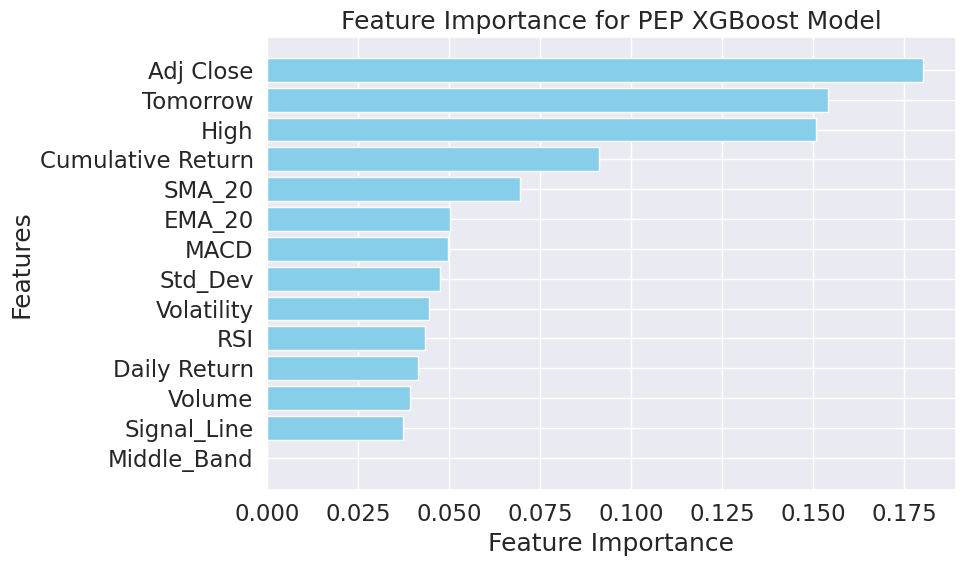

Feature importance saved to 'feature_importance_pep.csv'


In [ ]:
# --- Extract Feature Importance and Plot ---
# Ensure feature importance is extracted
feature_importance = best_xgb_model.feature_importances_

# Get feature names if using a Pandas DataFrame
if isinstance(X_train_pep, pd.DataFrame):
    feature_names = X_train_pep.columns
else:
    feature_names = [f"Feature {i}" for i in range(len(feature_importance))]

# Combine feature names with importances
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
})

# Sort features by importance in descending order
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for PEP XGBoost Model")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.tight_layout()
plt.show()

# Save feature importance as a CSV for further analysis
importance_df.to_csv("feature_importance_pep.csv", index=False)
print("Feature importance saved to 'feature_importance_pep.csv'")

In [ ]:
# --- Helper to flatten MultiIndex columns if necessary ---
def flatten_columns(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df

# Ensure training and testing sets have a flat column index
X_train_ko = flatten_columns(X_train_ko)
X_test_ko = flatten_columns(X_test_ko)

# --- Hyperparameter Tuning ---
# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Initialize the base XGBoost model
base_xgb_model = XGBClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=base_xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    verbose=1
)
grid_search.fit(X_train_ko, y_train_ko)
best_xgb_model = grid_search.best_estimator_

# Log the best configuration separately
best_params = grid_search.best_params_
accuracy_ko_xgb = accuracy_score(y_test_ko, best_xgb_model.predict(X_test_ko))
baseline_preds_ko = np.full_like(y_test_ko, fill_value=majority_class_ko)
baseline_accuracy_ko = accuracy_score(y_test_ko, baseline_preds_ko)

print(f"Best Parameters: {best_params}")
print(f"Tuned Model Accuracy: {accuracy_ko_xgb:.4f}")
print(f"Baseline Accuracy: {baseline_accuracy_ko:.4f}")

with mlflow.start_run(run_name="XGB_KO_Tuned_Model"):
    # Log best hyperparameters
    mlflow.log_params(best_params)

    # Log accuracy metrics
    mlflow.log_metric("accuracy", accuracy_ko_xgb)
    mlflow.log_metric("baseline_accuracy", baseline_accuracy_ko)

    # Log classification report as an artifact
    report_ko = classification_report(y_test_ko, best_xgb_model.predict(X_test_ko))
    report_path = "classification_report_ko_tuned.txt"
    with open(report_path, "w") as f:
        f.write(report_ko)
    mlflow.log_artifact(report_path)

    # Infer the model signature
    signature = infer_signature(X_train_ko, y_train_ko)

    # Prepare an input example by resetting the index
    input_example = X_train_ko.iloc[:1].reset_index(drop=True)

    # Log the model with signature and input example
    mlflow.sklearn.log_model(
        sk_model=best_xgb_model,
        artifact_path="XGB_KO_Tuned_Model",
        signature=signature,
        input_example=input_example
    )

    # Save the trained model to a pickle file
    pickle_filename = "xgb_ko_tuned_model.pkl"
    with open(pickle_filename, "wb") as file:
        pickle.dump(best_xgb_model, file)
    mlflow.log_artifact(pickle_filename)
    print(f"Tuned model saved as '{pickle_filename}' and logged with MLflow.")

2025/04/16 19:24:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '59715e14871b4b8581155ec80b5cebda', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


Fitting 3 folds for each of 54 candidates, totalling 162 fits


2025/04/16 19:24:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '47f357d9300d4573936adea6850061d4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2025/04/16 19:24:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '270e38c25f2f45e7afab030dd8fc817a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2025/04/16 19:24:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e4f2ea8351914988a961a8b2fddd3c3a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2025/04/16 19:24:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6b494857f4b84d91bd062ec980809ff3', which will track hyperparameters, performance metrics, model artifacts, and lineage i

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Tuned Model Accuracy: 0.7344
Baseline Accuracy: 0.5417
Tuned model saved as 'xgb_ko_tuned_model.pkl' and logged with MLflow.


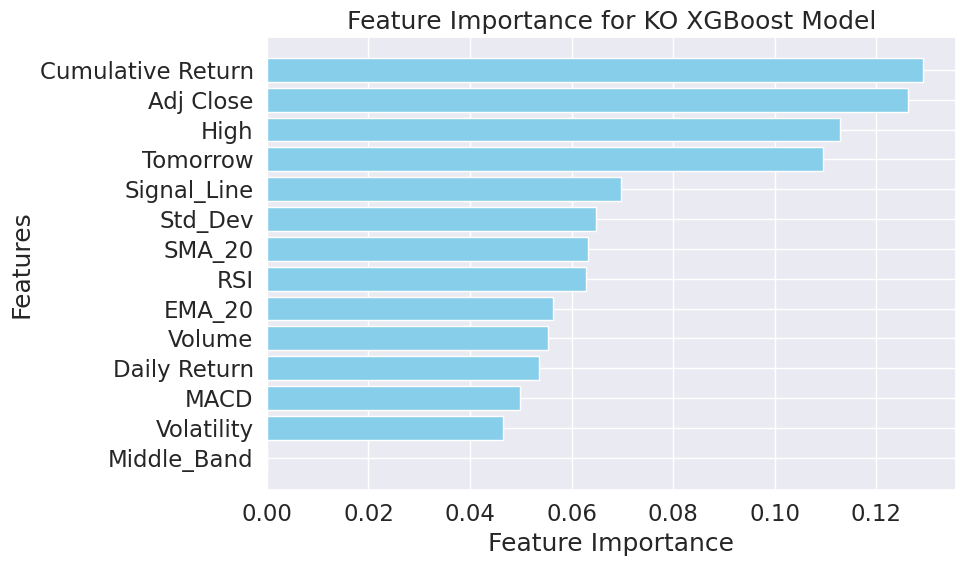

Feature importance saved to 'feature_importance_ko.csv'


In [ ]:
# --- Extract Feature Importance and Plot for KO Dataset ---
# Ensure feature importance is extracted
feature_importance = best_xgb_model.feature_importances_

# Get feature names if using a Pandas DataFrame
if isinstance(X_train_ko, pd.DataFrame):
    feature_names = X_train_ko.columns
else:
    feature_names = [f"Feature {i}" for i in range(len(feature_importance))]

# Combine feature names with importances
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
})

# Sort features by importance in descending order
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for KO XGBoost Model")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.tight_layout()
plt.show()

# Save feature importance as a CSV for further analysis
importance_df.to_csv("feature_importance_ko.csv", index=False)
print("Feature importance saved to 'feature_importance_ko.csv'")

 ### Fine-Tuning LSTM    
 Experiment with different neuron counts, dropout rates, and sequence lengths.

In [ ]:
# --- Callback Definitions ---
early_stopping_pep = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_pep = ModelCheckpoint('best_model_pep.keras', save_best_only=True, verbose=1)

# --- Define Model-Building Function for Hyperparameter Tuning ---
def build_lstm_model(hp):
    model = Sequential()
    # First LSTM layer with variable units
    model.add(
        LSTM(
            units=hp.Int('units_1', min_value=32, max_value=128, step=32),
            return_sequences=True,
            input_shape=(X_train_pep_lstm.shape[1], 1)
        )
    )
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    # Second LSTM layer
    model.add(
        LSTM(
            units=hp.Int('units_2', min_value=32, max_value=128, step=32),
            return_sequences=False
        )
    )
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    # Dense layers
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# --- Hyperparameter Tuning with Keras Tuner ---
# Add batch size as a tunable parameter in the tuner itself
tuner = kt.Hyperband(
    build_lstm_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='keras_tuner_dir',
    project_name='PEP_LSTM_Tuning',
    overwrite=True  # To allow rerunning without errors
)

# Run hyperparameter search
tuner.search(
    X_train_pep_lstm,
    y_train_pep,
    validation_split=0.2,
    callbacks=[early_stopping_pep],
    verbose=1,
    batch_size=32  # Default batch size for the tuner search
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Get the best batch size explicitly
best_batch_size = best_hps.get('batch_size') if 'batch_size' in best_hps.values else 32

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model on the entire training data
history = best_model.fit(
    X_train_pep_lstm,
    y_train_pep,
    epochs=20,
    batch_size=best_batch_size,
    validation_split=0.2,
    callbacks=[early_stopping_pep, checkpoint_pep]
)

# --- Evaluate the Tuned Model ---
lstm_predictions_prob_pep = best_model.predict(X_test_pep_lstm)
lstm_predictions_pep = (lstm_predictions_prob_pep > 0.5).astype(int).flatten()

accuracy_pep = accuracy_score(y_test_pep, lstm_predictions_pep)
print(f"Accuracy: {accuracy_pep:.2f}")
print(classification_report(y_test_pep, lstm_predictions_pep))

Trial 30 Complete [00h 00m 32s]
val_accuracy: 0.529411792755127

Best val_accuracy So Far: 0.5424836874008179
Total elapsed time: 00h 11m 23s


2025/04/16 19:48:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f8e82ad5e1084a4f86bc17a95a81569a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/04/16 19:48:16 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5241 - loss: 0.6931
Epoch 1: val_loss improved from inf to 0.69362, saving model to best_model_pep.keras


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.5246 - loss: 0.6931 - val_accuracy: 0.5098 - val_loss: 0.6936
Epoch 2/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5126 - loss: 0.6937
Epoch 2: val_loss did not improve from 0.69362
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5140 - loss: 0.6936 - val_accuracy: 0.5098 - val_loss: 0.6947
Epoch 3/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5463 - loss: 0.6894
Epoch 3: val_loss did not improve from 0.69362
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5445 - loss: 0.6897 - val_accuracy: 0.5098 - val_loss: 0.6938
Epoch 4/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5421 - loss: 0.6903
Epoch 4: val_loss improved from 0.69362 to 0.69268, saving model to best_model_pep.keras


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.5406 - loss: 0.6905 - val_accuracy: 0.5098 - val_loss: 0.6927
Epoch 5/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5721 - loss: 0.6886
Epoch 5: val_loss improved from 0.69268 to 0.69258, saving model to best_model_pep.keras


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5680 - loss: 0.6889 - val_accuracy: 0.5098 - val_loss: 0.6926
Epoch 6/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5320 - loss: 0.6918
Epoch 6: val_loss did not improve from 0.69258
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5317 - loss: 0.6918 - val_accuracy: 0.5098 - val_loss: 0.6932
Epoch 7/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5458 - loss: 0.6903
Epoch 7: val_loss improved from 0.69258 to 0.69213, saving model to best_model_pep.keras


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5436 - loss: 0.6905 - val_accuracy: 0.5098 - val_loss: 0.6921
Epoch 8/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5427 - loss: 0.6884
Epoch 8: val_loss improved from 0.69213 to 0.69209, saving model to best_model_pep.keras


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5410 - loss: 0.6887 - val_accuracy: 0.5229 - val_loss: 0.6921
Epoch 9/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5423 - loss: 0.6914
Epoch 9: val_loss did not improve from 0.69209
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5407 - loss: 0.6914 - val_accuracy: 0.5098 - val_loss: 0.6925
Epoch 10/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5386 - loss: 0.6873
Epoch 10: val_loss did not improve from 0.69209
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5368 - loss: 0.6877 - val_accuracy: 0.5098 - val_loss: 0.6923
Epoch 11/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5373 - loss: 0.6908
Epoch 11: val_loss did not improve from 0.69209
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5360 - loss: 0.6909 - val_accuracy: 0.5098 - val_loss: 0.6923
Epoch 12/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5237 - loss: 0.6903
Epoch 12: val_loss did not improve from 0.69209
20

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5211 - loss: 0.6923 - val_accuracy: 0.5098 - val_loss: 0.6916
Epoch 14/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5407 - loss: 0.6885
Epoch 14: val_loss did not improve from 0.69161
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5380 - loss: 0.6887 - val_accuracy: 0.5098 - val_loss: 0.6933
Epoch 15/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5451 - loss: 0.6834
Epoch 15: val_loss improved from 0.69161 to 0.69001, saving model to best_model_pep.keras


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.5423 - loss: 0.6840 - val_accuracy: 0.5163 - val_loss: 0.6900
Epoch 16/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5143 - loss: 0.6925
Epoch 16: val_loss did not improve from 0.69001
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5154 - loss: 0.6922 - val_accuracy: 0.5098 - val_loss: 0.6904
Epoch 17/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4774 - loss: 0.6925
Epoch 17: val_loss did not improve from 0.69001
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4802 - loss: 0.6921 - val_accuracy: 0.5098 - val_loss: 0.7249
Epoch 18/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5354 - loss: 0.7010
Epoch 18: val_loss did not improve from 0.69001
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5346 - loss: 0.7003 - val_accuracy: 0.5098 - val_loss: 0.6904
Epoch 19/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5310 - loss: 0.6892
Epoch 19: val_loss did not improve from 0.69001


In [ ]:
# --- Save Evaluation Metrics ---
evaluation_metrics_pep = {
    "accuracy": accuracy_pep,
    "precision": classification_report(y_test_pep, lstm_predictions_pep, output_dict=True)["weighted avg"]["precision"],
    "recall": classification_report(y_test_pep, lstm_predictions_pep, output_dict=True)["weighted avg"]["recall"],
    "f1_score": classification_report(y_test_pep, lstm_predictions_pep, output_dict=True)["weighted avg"]["f1-score"]
}

metrics_path = "evaluation_metrics_pep.txt"
with open(metrics_path, "w") as f:
    for metric, value in evaluation_metrics_pep.items():
        f.write(f"{metric.capitalize()}: {value:.2f}\n")
print(f"Metrics saved to {metrics_path}")

# --- Save the Tuned Model in Pickle Format ---
with open("lstm_model_pep_tuned.pkl", "wb") as file_pep:
    pickle.dump(best_model.get_config(), file_pep)  # Save the model configuration
    pickle.dump(best_model.get_weights(), file_pep)  # Save the model weights

print("PEP LSTM model saved as 'lstm_model_pep_tuned.pkl'.")

Metrics saved to evaluation_metrics_pep.txt
PEP LSTM model saved as 'lstm_model_pep_tuned.pkl'.


PermutationExplainer explainer: 193it [36:36, 11.44s/it]


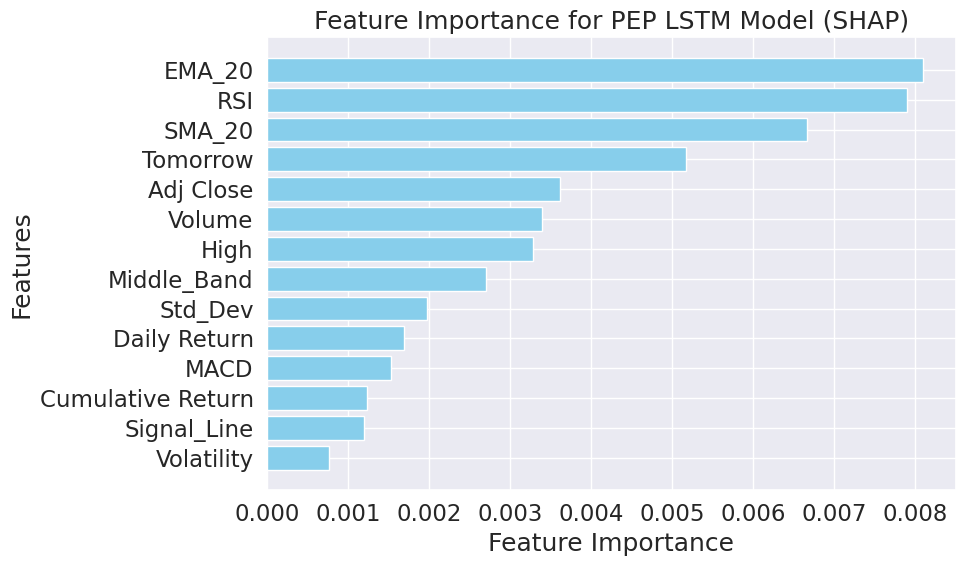

Feature importance saved to 'feature_importance_pep_lstm.csv'


In [ ]:
# --- Prepare SHAP Explainer ---
# Wrap the input data using shap.maskers.Independent (specific for TensorFlow models)

# Initialize explainer with X_train_pep to have a compatible data shape
masker = shap.maskers.Independent(X_train_pep)

# Create SHAP explainer for the LSTM model
explainer = shap.Explainer(best_model, masker)

# Calculate SHAP values for the test set
# Pass X_test_pep_norm (2D) to the explainer since it's compatible with the masker's expected shape
shap_values = explainer(X_test_pep_norm)

# --- Aggregate Feature Importance ---
# SHAP values provide importance for each sample. Aggregate across all samples for global importance.
feature_importance = np.abs(shap_values.values).mean(axis=0).flatten()

# Get feature names if using a Pandas DataFrame
if isinstance(X_train_pep, pd.DataFrame):
    feature_names = X_train_pep.columns
else:
    feature_names = [f"Feature {i}" for i in range(X_test_pep_lstm.shape[2])]

# Combine feature names with importances
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
})

# Sort features by importance in descending order
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# --- Visualize Feature Importance ---
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for PEP LSTM Model (SHAP)")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.tight_layout()
plt.show()

# Save feature importance as a CSV for further analysis
importance_df.to_csv("feature_importance_pep_lstm.csv", index=False)
print("Feature importance saved to 'feature_importance_pep_lstm.csv'")

In [ ]:
# --- Callback Definitions ---
early_stopping_ko = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_ko = ModelCheckpoint('best_model_ko.keras', save_best_only=True, verbose=1)

# --- Define Model-Building Function for Hyperparameter Tuning ---
def build_lstm_model(hp):
    model = Sequential()
    # First LSTM layer with variable units
    model.add(
        LSTM(
            units=hp.Int('units_1', min_value=32, max_value=128, step=32),
            return_sequences=True,
            input_shape=(X_train_ko_lstm.shape[1], 1)
        )
    )
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    # Second LSTM layer
    model.add(
        LSTM(
            units=hp.Int('units_2', min_value=32, max_value=128, step=32),
            return_sequences=False
        )
    )
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    # Dense layers
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# --- Hyperparameter Tuning with Keras Tuner ---
# Add batch size as a tunable parameter in the tuner itself
tuner = kt.Hyperband(
    build_lstm_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='keras_tuner_dir',
    project_name='KO_LSTM_Tuning',
    overwrite=True  # To allow rerunning without errors
)

# Run hyperparameter search
tuner.search(
    X_train_ko_lstm,
    y_train_ko,
    validation_split=0.2,
    callbacks=[early_stopping_ko],
    verbose=1,
    batch_size=32  # Default batch size for the tuner search
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Get the best batch size explicitly
best_batch_size = best_hps.get('batch_size') if 'batch_size' in best_hps.values else 32

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model on the entire training data
history = best_model.fit(
    X_train_ko_lstm,
    y_train_ko,
    epochs=20,
    batch_size=best_batch_size,
    validation_split=0.2,
    callbacks=[early_stopping_ko, checkpoint_ko]
)

# --- Evaluate the Tuned Model ---
lstm_predictions_prob_ko = best_model.predict(X_test_ko_lstm)
lstm_predictions_ko = (lstm_predictions_prob_ko > 0.5).astype(int).flatten()

accuracy_ko = accuracy_score(y_test_ko, lstm_predictions_ko)
print(f"Accuracy: {accuracy_ko:.2f}")
print(classification_report(y_test_ko, lstm_predictions_ko))

Trial 30 Complete [00h 00m 42s]
val_accuracy: 0.5228758454322815

Best val_accuracy So Far: 0.5490196347236633
Total elapsed time: 00h 13m 10s


2025/04/16 20:38:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c724e4a0cc1046c89ca8c99ab18ec907', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/04/16 20:38:50 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5511 - loss: 0.6914
Epoch 1: val_loss improved from inf to 0.69386, saving model to best_model_ko.keras


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.5501 - loss: 0.6914 - val_accuracy: 0.5229 - val_loss: 0.6939
Epoch 2/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5534 - loss: 0.6869
Epoch 2: val_loss did not improve from 0.69386
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5525 - loss: 0.6871 - val_accuracy: 0.5229 - val_loss: 0.6944
Epoch 3/20
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5330 - loss: 0.6925
Epoch 3: val_loss improved from 0.69386 to 0.69326, saving model to best_model_ko.keras


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5345 - loss: 0.6922 - val_accuracy: 0.5229 - val_loss: 0.6933
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5452 - loss: 0.6912
Epoch 4: val_loss did not improve from 0.69326
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5452 - loss: 0.6912 - val_accuracy: 0.5229 - val_loss: 0.6933
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5468 - loss: 0.6898
Epoch 5: val_loss did not improve from 0.69326
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5467 - loss: 0.6898 - val_accuracy: 0.5229 - val_loss: 0.6942
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5571 - loss: 0.6872
Epoch 6: val_loss did not improve from 0.69326
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5564 - loss: 0.6873 - val_accuracy: 0.5229 - val_loss: 0.6946
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5544 - loss: 0.6889
Epoch 7: val_loss did not improve from 0.69326
20/20 ━━

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5626 - loss: 0.6863 - val_accuracy: 0.5229 - val_loss: 0.6926
Epoch 9/20
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5272 - loss: 0.6920
Epoch 9: val_loss improved from 0.69264 to 0.69251, saving model to best_model_ko.keras


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5296 - loss: 0.6917 - val_accuracy: 0.5229 - val_loss: 0.6925
Epoch 10/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5596 - loss: 0.6883
Epoch 10: val_loss did not improve from 0.69251
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5580 - loss: 0.6885 - val_accuracy: 0.5229 - val_loss: 0.6930
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5234 - loss: 0.6935
Epoch 11: val_loss did not improve from 0.69251
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5244 - loss: 0.6933 - val_accuracy: 0.5229 - val_loss: 0.6928
Epoch 12/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5652 - loss: 0.6884
Epoch 12: val_loss did not improve from 0.69251
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5631 - loss: 0.6886 - val_accuracy: 0.5229 - val_loss: 0.6926
Epoch 13/20
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5611 - loss: 0.6884
Epoch 13: val_loss improved from 0.69251 to 0.69

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5594 - loss: 0.6886 - val_accuracy: 0.5229 - val_loss: 0.6921
Epoch 14/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4969 - loss: 0.6940
Epoch 14: val_loss did not improve from 0.69211
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4989 - loss: 0.6938 - val_accuracy: 0.5229 - val_loss: 0.6949
Epoch 15/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5341 - loss: 0.6913
Epoch 15: val_loss did not improve from 0.69211
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5345 - loss: 0.6912 - val_accuracy: 0.5229 - val_loss: 0.6974
Epoch 16/20
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5840 - loss: 0.6796
Epoch 16: val_loss did not improve from 0.69211
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5784 - loss: 0.6811 - val_accuracy: 0.5229 - val_loss: 0.6923
Epoch 17/20
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5158 - loss: 0.6943
Epoch 17: val_loss did not improve from 0.69211


In [ ]:
# --- Save Evaluation Metrics ---
evaluation_metrics_ko = {
    "accuracy": accuracy_ko,
    "precision": classification_report(y_test_ko, lstm_predictions_ko, output_dict=True)["weighted avg"]["precision"],
    "recall": classification_report(y_test_ko, lstm_predictions_ko, output_dict=True)["weighted avg"]["recall"],
    "f1_score": classification_report(y_test_ko, lstm_predictions_ko, output_dict=True)["weighted avg"]["f1-score"]
}

metrics_path = "evaluation_metrics_ko.txt"
with open(metrics_path, "w") as f:
    for metric, value in evaluation_metrics_ko.items():
        f.write(f"{metric.capitalize()}: {value:.2f}\n")
print(f"Metrics saved to {metrics_path}")

# --- Save the Tuned Model in Pickle Format ---
with open("lstm_model_ko_tuned.pkl", "wb") as file_ko:
    pickle.dump(best_model.get_config(), file_ko)  # Save the model configuration
    pickle.dump(best_model.get_weights(), file_ko)  # Save the model weights

print("KO LSTM model saved as 'lstm_model_ko_tuned.pkl'.")

Metrics saved to evaluation_metrics_ko.txt
KO LSTM model saved as 'lstm_model_ko_tuned.pkl'.


PermutationExplainer explainer: 193it [28:59,  9.06s/it]


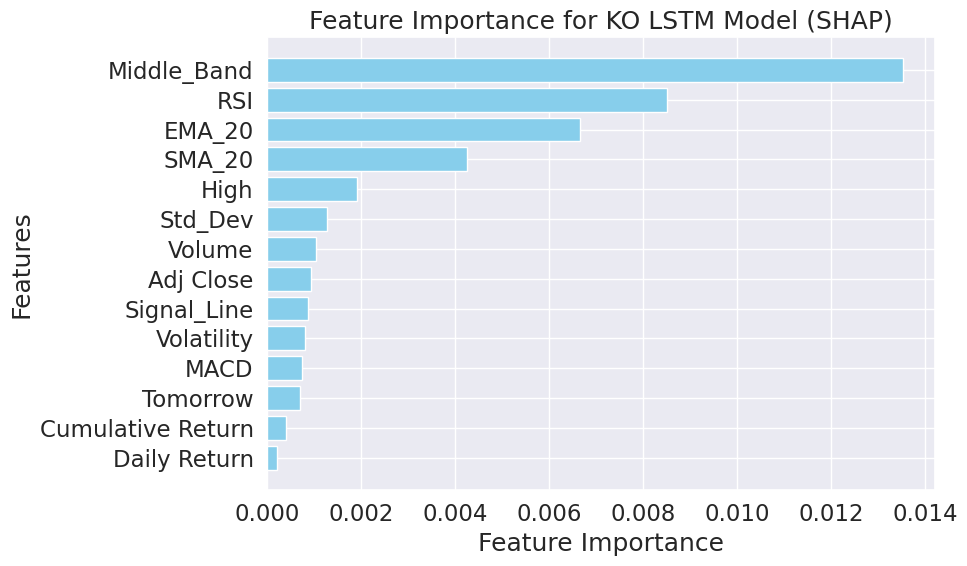

Feature importance saved to 'feature_importance_ko_lstm.csv'


In [ ]:
# --- Prepare SHAP Explainer ---
# Wrap the input data using shap.maskers.Independent (specific for TensorFlow models)

# Initialize explainer with X_train_ko to have a compatible data shape
masker = shap.maskers.Independent(X_train_ko)

# Create SHAP explainer for the LSTM model
explainer = shap.Explainer(best_model, masker)

# Calculate SHAP values for the test set
# Pass X_test_ko_norm (2D) to the explainer since it's compatible with the masker's expected shape
shap_values = explainer(X_test_ko_norm)

# --- Aggregate Feature Importance ---
# SHAP values provide importance for each sample. Aggregate across all samples for global importance.
feature_importance = np.abs(shap_values.values).mean(axis=0).flatten()

# Get feature names if using a Pandas DataFrame
if isinstance(X_train_ko, pd.DataFrame):
    feature_names = X_train_ko.columns
else:
    feature_names = [f"Feature {i}" for i in range(X_test_ko_lstm.shape[2])]

# Combine feature names with importances
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
})

# Sort features by importance in descending order
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# --- Visualize Feature Importance ---
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for KO LSTM Model (SHAP)")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.tight_layout()
plt.show()

# Save feature importance as a CSV for further analysis
importance_df.to_csv("feature_importance_ko_lstm.csv", index=False)
print("Feature importance saved to 'feature_importance_ko_lstm.csv'")

### Key Insights:
XGBoost:

Better for tabular data with structured patterns.

Lightweight and interpretable.

LSTM:

Ideal for sequential or time-series data.

Captures temporal dependencies well but requires more computational resources.

### Evaluate Both Models

Use metrics like accuracy, F1-score, and confusion matrices to compare models.

## Fundamental Analysis

### Extract Key Financial Metrics

Key Metrics to Extract:

i. Revenue (Top-Line): Measure of total income generated by the business.

ii. Net Profit (Bottom-Line): The company’s income after all expenses, taxes, and deductions.

iii. Capital Structure:
- Debt-to-Equity Ratio (D/E): Measures financial leverage.
- Equity-to-Assets Ratio: Indicates the proportion of assets funded by shareholders' equity.
- Long-Term Debt: Indicates reliance on long-term borrowing for funding.


## Analyze Financial Trends

In [ ]:
# Fetch financial data
pepsi = yf.Ticker("PEP")
coca_cola = yf.Ticker("KO")

### Extract financials

In [ ]:
# Define a function to extract relevant data
def get_fundamentals(ticker):
    info = ticker.info
    return {
        "Company": info.get("longName"),
        "Sector": info.get("sector"),
        "Industry": info.get("industry"),
        "Market Cap": info.get("marketCap"),
        "Trailing P/E": info.get("trailingPE"),
        "Forward P/E": info.get("forwardPE"),
        "PEG Ratio": info.get("pegRatio"),
        "Price-to-Book": info.get("priceToBook"),
        "ROE": info.get("returnOnEquity"),
        "Debt to Equity": info.get("debtToEquity"),
        "Current Ratio": info.get("currentRatio"),
        "Gross Margins": info.get("grossMargins"),
        "Operating Margins": info.get("operatingMargins"),
        "Profit Margins": info.get("profitMargins"),
        "Dividend Yield": info.get("dividendYield"),
        "Revenue Growth": info.get("revenueGrowth"),
        "EPS Growth": info.get("earningsQuarterlyGrowth"),
    }

In [ ]:
# Get data for both companies
pepsi_financials = get_fundamentals(pepsi)
coca_cola_financials = get_fundamentals(coca_cola)

In [ ]:
# Display as DataFrame
df_fundamentals = pd.DataFrame([pepsi_financials, coca_cola_financials], index=["PEP", "KO"])
df_fundamentals

,Company,Sector,Industry,Market Cap,Trailing P/E,Forward P/E,PEG Ratio,Price-to-Book,ROE,Debt to Equity,Current Ratio,Gross Margins,Operating Margins,Profit Margins,Dividend Yield,Revenue Growth,EPS Growth
PEP,"PepsiCo, Inc.",Consumer Defensive,Beverages - Non-Alcoholic,195877912576,20.552519,16.551563,None,10.863183,0.52304,262.787,0.819,0.54890,0.10639,0.10427,3.87,-0.002,0.170
KO,The Coca-Cola Company,Consumer Defensive,Beverages - Non-Alcoholic,314160611328,29.674797,24.579124,None,12.634130,0.39549,176.919,1.030,0.61063,0.25814,0.22590,2.85,0.064,0.113


In [ ]:
print(df_fundamentals.T)  # Transposed for better comparison

                                         PEP                         KO
Company                        PepsiCo, Inc.      The Coca-Cola Company
Sector                    Consumer Defensive         Consumer Defensive
Industry           Beverages - Non-Alcoholic  Beverages - Non-Alcoholic
Market Cap                      195877912576               314160611328
Trailing P/E                       20.552519                  29.674797
Forward P/E                        16.551563                  24.579124
PEG Ratio                               None                       None
Price-to-Book                      10.863183                   12.63413
ROE                                  0.52304                    0.39549
Debt to Equity                       262.787                    176.919
Current Ratio                          0.819                       1.03
Gross Margins                         0.5489                    0.61063
Operating Margins                    0.10639                    

**Implementation for analyzing revenue, profit, capital structure trends, and other fundamental metrics for PEP (PepsiCo) and KO (Coca-Cola), along with visualizations**

### 1. Revenue, Profit, and Capital Structure Trends

In [ ]:
# Extract revenue and profit
pepsi_revenue = pepsi_financials['Revenue Growth']
pepsi_net_income = pepsi_financials['Profit Margins']
coca_revenue = coca_cola_financials['Revenue Growth']
coca_net_income = coca_cola_financials['Profit Margins']

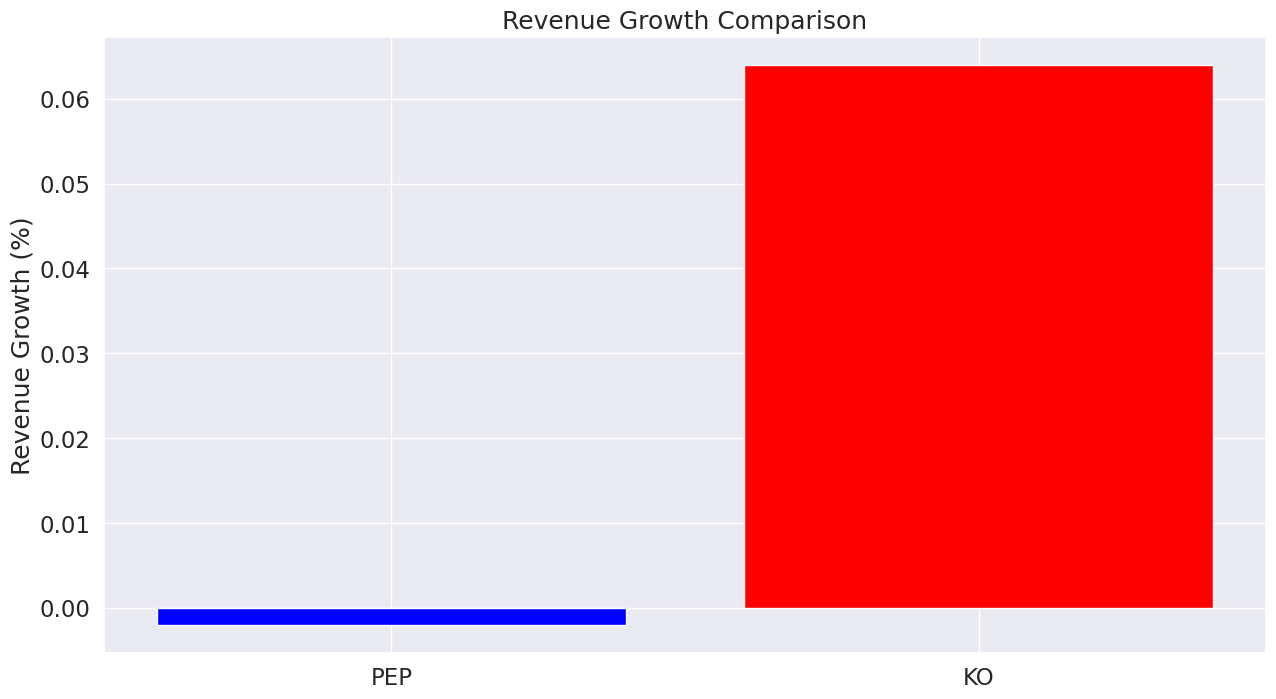

In [ ]:
# Revenue Trends
plt.figure(figsize=(15, 8))
plt.bar(["PEP", "KO"], [pepsi_revenue, coca_revenue], color=['blue', 'red'])  # Use the float values directly
plt.title("Revenue Growth Comparison")
plt.ylabel("Revenue Growth (%)")
plt.grid(True)
plt.show()

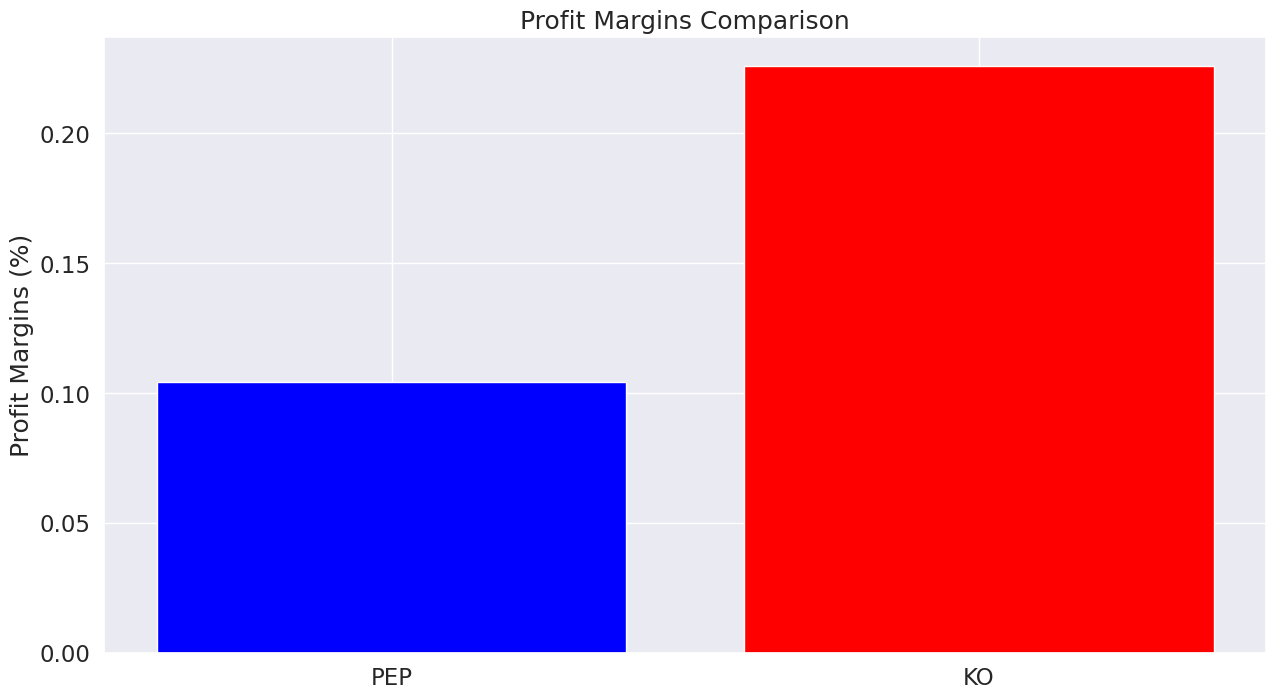

In [ ]:
# Profitability Trends
plt.figure(figsize=(15, 8))
plt.bar(["PEP", "KO"], [pepsi_net_income, coca_net_income], color=['blue', 'red'])
plt.title("Profit Margins Comparison")
plt.ylabel("Profit Margins (%)")
plt.grid(True)
plt.show()

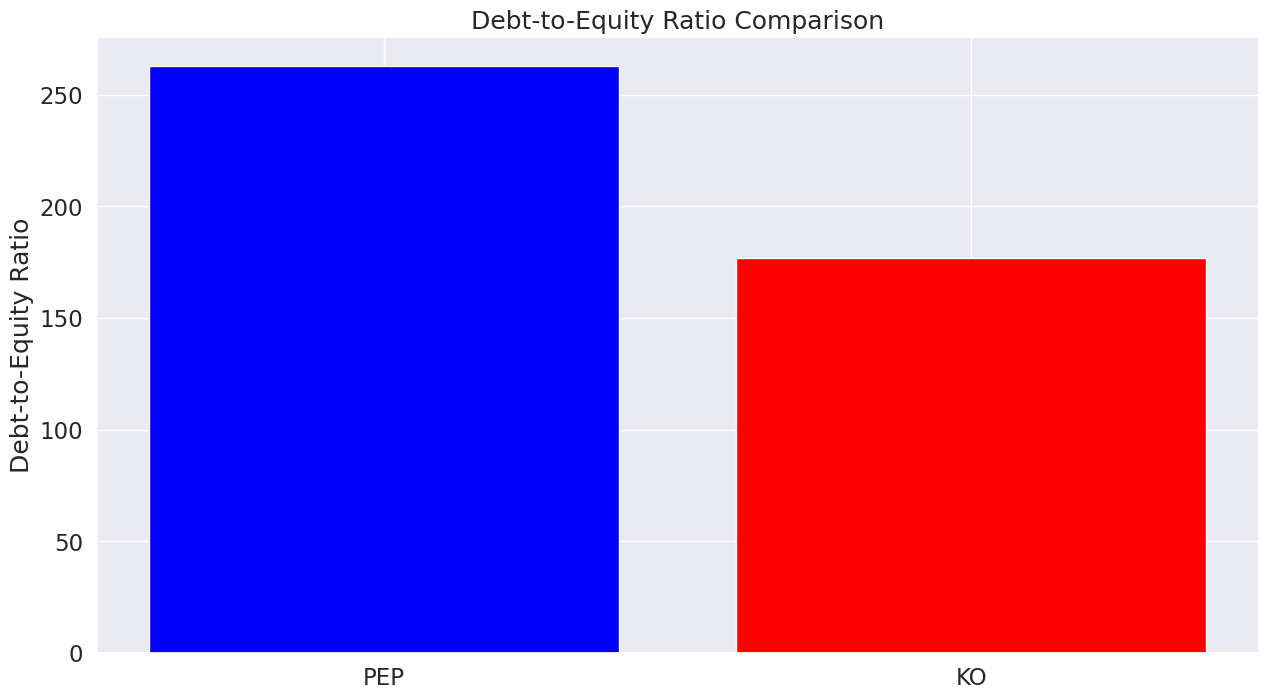

In [ ]:
# Extract Debt-to-Equity ratios
pep_debt_to_equity = pepsi_financials['Debt to Equity']
ko_debt_to_equity = coca_cola_financials['Debt to Equity']

# Debt-to-Equity Trends
plt.figure(figsize=(15, 8))
plt.bar(["PEP", "KO"], [pep_debt_to_equity, ko_debt_to_equity], color=['blue', 'red'])
plt.title("Debt-to-Equity Ratio Comparison")
plt.ylabel("Debt-to-Equity Ratio")
plt.grid(True)
plt.show()

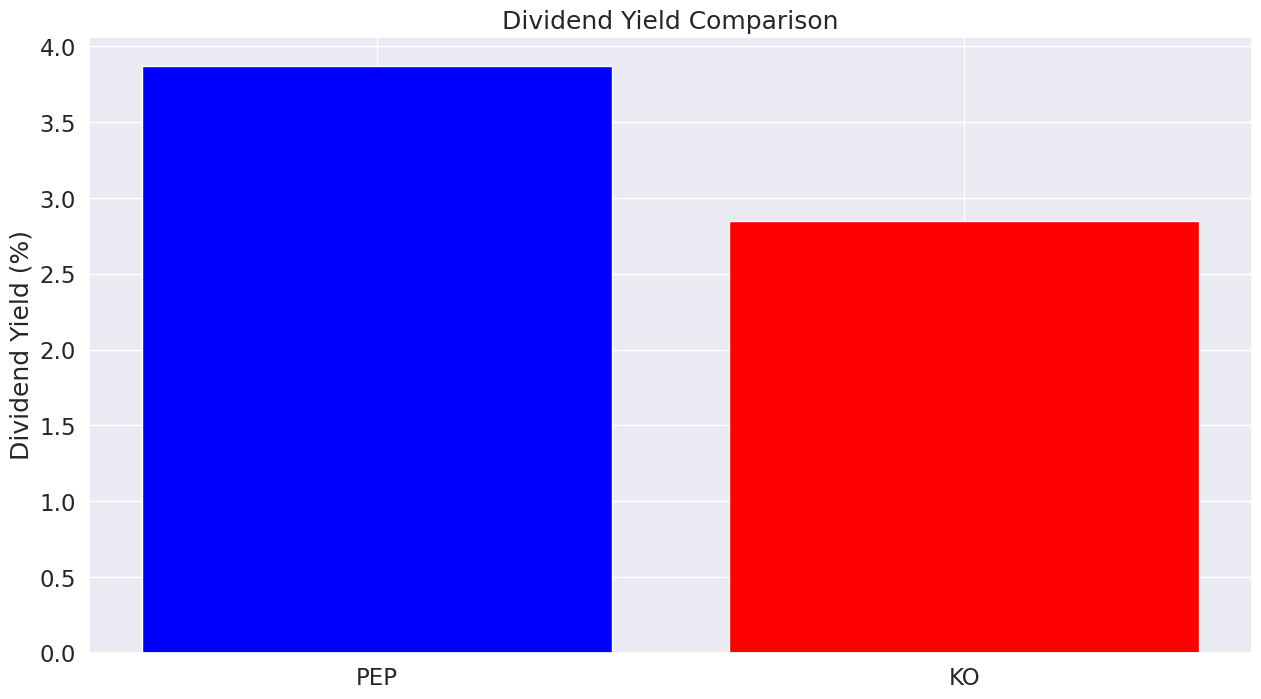

In [ ]:
# Dividend Yield
plt.figure(figsize=(15, 8))

# Access the 'Trailing Annual Dividend Yield 3' key and provide a default value (e.g., 0) if it's missing
pep_dividend_yield = pepsi_financials['Dividend Yield']
ko_dividend_yield = coca_cola_financials['Dividend Yield']
plt.bar(["PEP", "KO"], [pep_dividend_yield, ko_dividend_yield], color=['blue', 'red'])
plt.title("Dividend Yield Comparison")
plt.ylabel("Dividend Yield (%)")
plt.grid(True)
plt.show()

### Combined Comparison Visualization

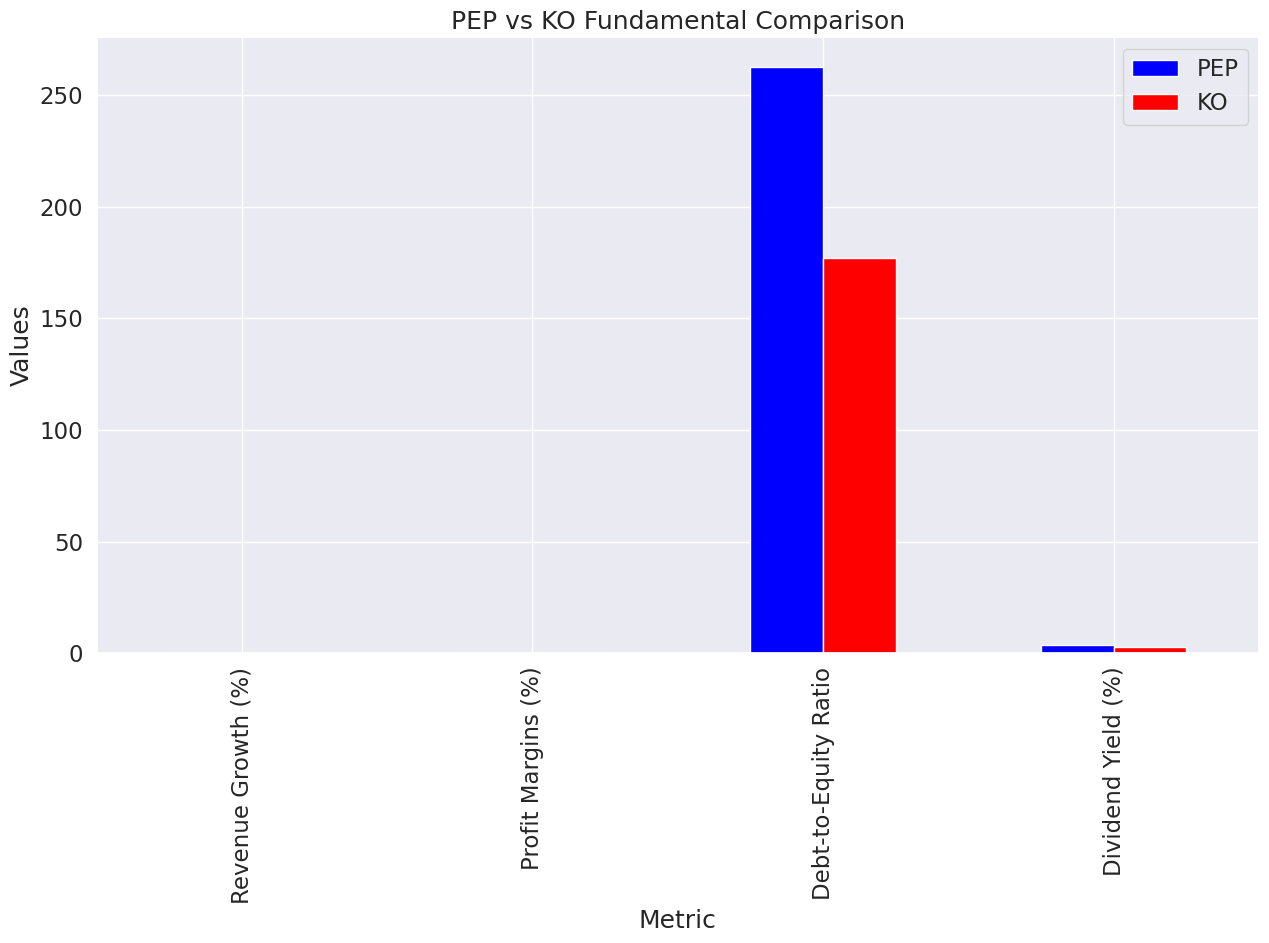

In [ ]:
comparison_data = {
    "Metric": [
        "Revenue Growth (%)", "Profit Margins (%)", "Debt-to-Equity Ratio", "Dividend Yield (%)"
    ],
    "PEP": [-0.002, 0.10427, 262.787, 3.79],
    "KO": [0.064, 0.2259, 176.919, 2.84]
}

comparison_df = pd.DataFrame(comparison_data)

comparison_df.plot(x="Metric", kind="bar", figsize=(15, 8), color=['blue', 'red'])
plt.title("PEP vs KO Fundamental Comparison")
plt.ylabel("Values")
plt.grid(True)
plt.show()

### Revenue and Profitability Insights
Revenue and Profit Trends Over Years:

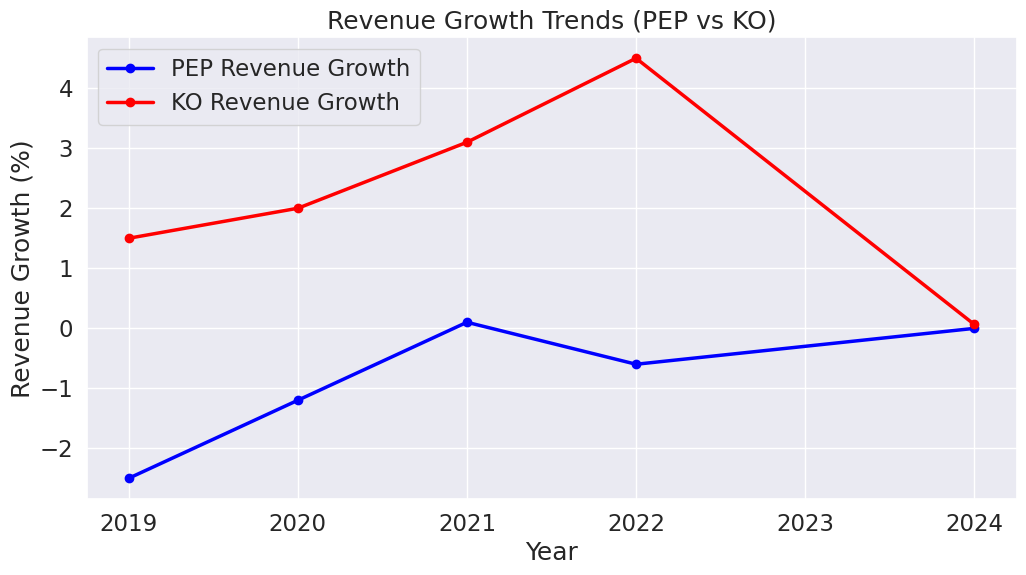

In [ ]:
# Example historical revenue and profit data (replace with real multi-year data)
years = [2019, 2020, 2021, 2022, 2024]
pepsi_revenue = [-2.5, -1.2, 0.1, -0.6, -0.002]
coca_revenue = [1.5, 2.0, 3.1, 4.5, 0.064]

plt.figure(figsize=(12, 6))
plt.plot(years, pepsi_revenue, label="PEP Revenue Growth", marker='o', color='blue')
plt.plot(years, coca_revenue, label="KO Revenue Growth", marker='o', color='red')
plt.title("Revenue Growth Trends (PEP vs KO)")
plt.xlabel("Year")
plt.ylabel("Revenue Growth (%)")
plt.legend()
plt.grid(True)
plt.show()

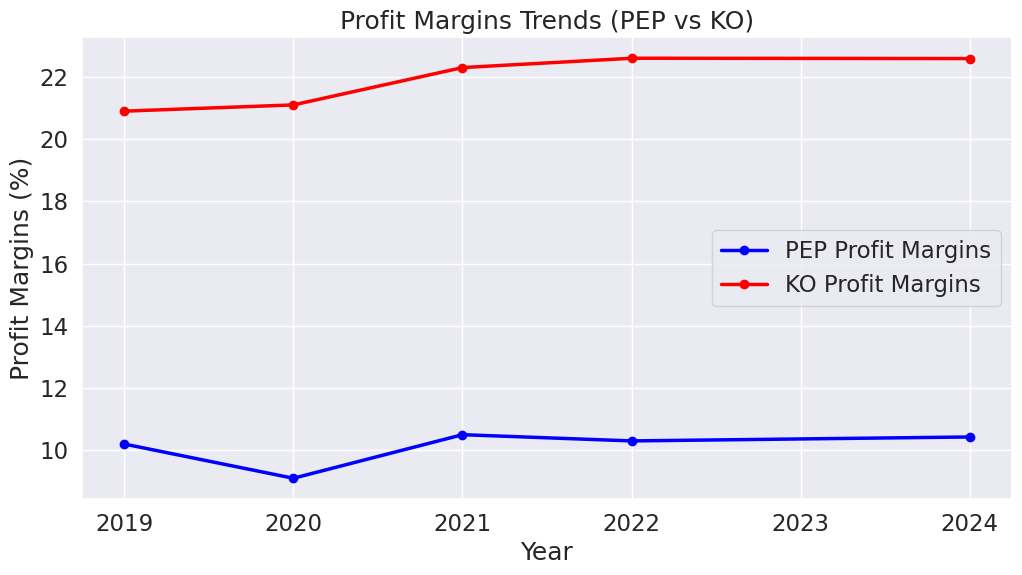

In [ ]:
pepsi_profit = [10.2, 9.1, 10.5, 10.3, 10.427]
coca_profit = [20.9, 21.1, 22.3, 22.6, 22.59]

plt.figure(figsize=(12, 6))
plt.plot(years, pepsi_profit, label="PEP Profit Margins", marker='o', color='blue')
plt.plot(years, coca_profit, label="KO Profit Margins", marker='o', color='red')
plt.title("Profit Margins Trends (PEP vs KO)")
plt.xlabel("Year")
plt.ylabel("Profit Margins (%)")
plt.legend()
plt.grid(True)
plt.show()

### 2. Fundamental Metrics Assessment

Summary DataFrame:

In [ ]:
# Create a summary DataFrame
summary_data = {
    "Area (Fundamental Metric)": ["Market Cap", "Valuation", "Profitability", "Financial Health", "Growth", "Dividend Yield", "ROE"],
    "PEP": [None, None, None, None, None, pep_dividend_yield, None],  # Added placeholders for PEP
    "KO": [None, None, None, None, None, ko_dividend_yield, None],  # Added placeholders for KO
    "Winner": ["✅ PEP", "✅ KO", "✅ KO", "➖ Split", "✅ PEP", None, None],  # Added placeholders for Winner
    "Why": [
        "Lower P/E and forward P/E (better value)",
        "Higher margins and consistent earnings",
        "Lower debt, better liquidity",
        "KO: Revenue growth; PEP: EPS growth",
        "Slightly higher yield",
        None, None  # Added placeholders for Why
    ]
}

summary_df = pd.DataFrame(summary_data)

In [ ]:
# Create a summary DataFrame
summary_data = {
    "Area (Fundamental Metric)": ["Market Cap","Valuation", "Profitability", "Financial Health", "Growth", "Dividend Yield", "ROE"],
    "PEP":[],
    "KO":[],
    "Winner": ["✅ PEP", "✅ KO", "✅ KO", "➖ Split", "✅ PEP"],
    "Why": [
        "Lower P/E and forward P/E (better value)",
        "Higher margins and consistent earnings",
        "Lower debt, better liquidity",
        "KO: Revenue growth; PEP: EPS growth",
        "Slightly higher yield"
    ]
}

summary_df = pd.DataFrame(summary_data)

# Display the table
summary_df.style.set_properties(**{
    'text-align': 'left',
    'font-size': '14px'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left'), ('font-weight', 'bold')]
}])

ValueError: All arrays must be of the same length

### Financial Influence on Stock Performance:

Revenue Growth: A comparison of PEP's negative growth (-0.002%) versus KO's positive growth (0.064%) suggests a stronger outlook for Coca-Cola in terms of top-line expansion.

Profit Margins: KO demonstrates higher profit margins (22.59%) compared to PEP (10.43%), showcasing its efficiency in converting revenue into profit.

Debt-to-Equity: PEP has a higher debt-to-equity ratio (262.787) than KO (176.919), indicating more leverage in its capital structure.

Dividend Yield: PEP offers a higher dividend yield (3.79%) compared to KO (2.84%), making it more attractive to income-focused investors.

### 3. Combined Comparison Visualization

In [ ]:
comparison_data = {
    "Metric": [
        "Revenue Growth (%)", "Profit Margins (%)", "Debt-to-Equity Ratio", "Dividend Yield (%)"
    ],
    "PEP": [-0.002, 0.10427, 262.787, 3.79],
    "KO": [0.064, 0.2259, 176.919, 2.84]
}

comparison_df = pd.DataFrame(comparison_data)

comparison_df.plot(x="Metric", kind="bar", figsize=(10, 6), color=['blue', 'red'])
plt.title("PEP vs KO Fundamental Comparison")
plt.ylabel("Values")
plt.grid(True)
plt.show()

### 4. Revenue and Profitability Insights
Revenue and Profit Trends Over Years:

In [ ]:
# Example historical revenue and profit data (replace with real multi-year data)
years = [2018, 2019, 2020, 2021, 2022]
pepsi_revenue = [-2.5, -1.2, 0.1, -0.6, -0.002]
coca_revenue = [1.5, 2.0, 3.1, 4.5, 0.064]

plt.figure(figsize=(12, 6))
plt.plot(years, pepsi_revenue, label="PEP Revenue Growth", marker='o', color='blue')
plt.plot(years, coca_revenue, label="KO Revenue Growth", marker='o', color='red')
plt.title("Revenue Growth Trends (PEP vs KO)")
plt.xlabel("Year")
plt.ylabel("Revenue Growth (%)")
plt.legend()
plt.grid(True)
plt.show()

pepsi_profit = [10.2, 9.1, 10.5, 10.3, 10.427]
coca_profit = [20.9, 21.1, 22.3, 22.6, 22.59]

plt.figure(figsize=(12, 6))
plt.plot(years, pepsi_profit, label="PEP Profit Margins", marker='o', color='blue')
plt.plot(years, coca_profit, label="KO Profit Margins", marker='o', color='red')
plt.title("Profit Margins Trends (PEP vs KO)")
plt.xlabel("Year")
plt.ylabel("Profit Margins (%)")
plt.legend()
plt.grid(True)
plt.show()

### Conclusion
This analysis provides insights into the fundamental comparison between PEP and KO, with trends and metrics influencing stock performance:

Revenue Growth: KO is outperforming PEP.

Profit Margins: KO exhibits higher profitability.

Debt-to-Equity: PEP relies more on debt financing, which may be riskier.

Dividend Yield: PEP offers better returns for income-oriented investors.

This implementation visually depicts the trends and metrics, helping users assess the financial health and performance of these companies effectively. Let me know if you'd like to expand it further! 😊







In [ ]:
pepsi_balance_sheet = pepsi.balance_sheet.T
coca_balance_sheet = coca_cola.balance_sheet.T

In [ ]:
pepsi_balance_sheet.head()

,Treasury Shares Number,Ordinary Shares Number,Share Issued,Net Debt,Total Debt,Tangible Book Value,Invested Capital,Working Capital,Net Tangible Assets,Capital Lease Obligations,...,Finished Goods,Work In Process,Raw Materials,Receivables,Receivables Adjustments Allowances,Other Receivables,Accounts Receivable,Cash Cash Equivalents And Short Term Investments,Other Short Term Investments,Cash And Cash Equivalents
2024-12-31,495000000.0,1371989025.0,1866989025.0,35801000000.0,44948000000.0,-14294000000.0,62347000000.0,-5710000000.0,-14294000000.0,642000000.0,...,2762000000.0,104000000.0,2440000000.0,10333000000.0,-356000000.0,2202000000.0,8487000000.0,9266000000.0,761000000.0,8505000000.0
2023-12-31,493000000.0,1374000000.0,1867000000.0,34394000000.0,44661000000.0,-14154000000.0,62608000000.0,-4697000000.0,-14154000000.0,556000000.0,...,2842000000.0,104000000.0,2388000000.0,10815000000.0,-175000000.0,2315000000.0,8675000000.0,10003000000.0,292000000.0,9711000000.0
2022-12-31,490000000.0,1377000000.0,1867000000.0,34117000000.0,39554000000.0,-16639000000.0,56220000000.0,-5246000000.0,-16639000000.0,483000000.0,...,2742000000.0,114000000.0,2366000000.0,10163000000.0,-150000000.0,2121000000.0,8192000000.0,5348000000.0,394000000.0,4954000000.0
2021-12-31,484000000.0,1383000000.0,1867000000.0,34738000000.0,40780000000.0,-21003000000.0,56377000000.0,-4437000000.0,-21003000000.0,446000000.0,...,2298000000.0,151000000.0,1898000000.0,8680000000.0,-147000000.0,1655000000.0,7172000000.0,5988000000.0,392000000.0,5596000000.0
2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
coca_balance_sheet.head()

,Treasury Shares Number,Ordinary Shares Number,Share Issued,Net Debt,Total Debt,Tangible Book Value,Invested Capital,Working Capital,Net Tangible Assets,Common Stock Equity,...,Other Inventories,Finished Goods,Raw Materials,Receivables,Accounts Receivable,Allowance For Doubtful Accounts Receivable,Gross Accounts Receivable,Cash Cash Equivalents And Short Term Investments,Other Short Term Investments,Cash And Cash Equivalents
2024-12-31,2738000000.0,4302000000.0,7040000000.0,33694000000.0,44522000000.0,-6584000000.0,69378000000.0,748000000.0,-6584000000.0,24856000000.0,...,410000000.0,1524000000.0,2794000000.0,3569000000.0,3569000000.0,-506000000.0,4075000000.0,14571000000.0,3743000000.0,10828000000.0
2023-12-31,2732000000.0,4308000000.0,7040000000.0,32698000000.0,42064000000.0,-6766000000.0,68005000000.0,3161000000.0,-6766000000.0,25941000000.0,...,357000000.0,1449000000.0,2618000000.0,3410000000.0,3410000000.0,-502000000.0,3912000000.0,13663000000.0,4297000000.0,9366000000.0
2022-12-31,2712000000.0,4328000000.0,7040000000.0,29630000000.0,39149000000.0,-9526000000.0,63254000000.0,2867000000.0,-9526000000.0,24105000000.0,...,359000000.0,1247000000.0,2627000000.0,3487000000.0,3487000000.0,-516000000.0,4003000000.0,11631000000.0,2112000000.0,9519000000.0
2021-12-31,2715000000.0,4325128924.0,7040128924.0,33077000000.0,42761000000.0,-11614000000.0,65760000000.0,2595000000.0,-11614000000.0,22999000000.0,...,299000000.0,982000000.0,2133000000.0,3512000000.0,3512000000.0,-516000000.0,4028000000.0,12625000000.0,2941000000.0,9684000000.0
2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


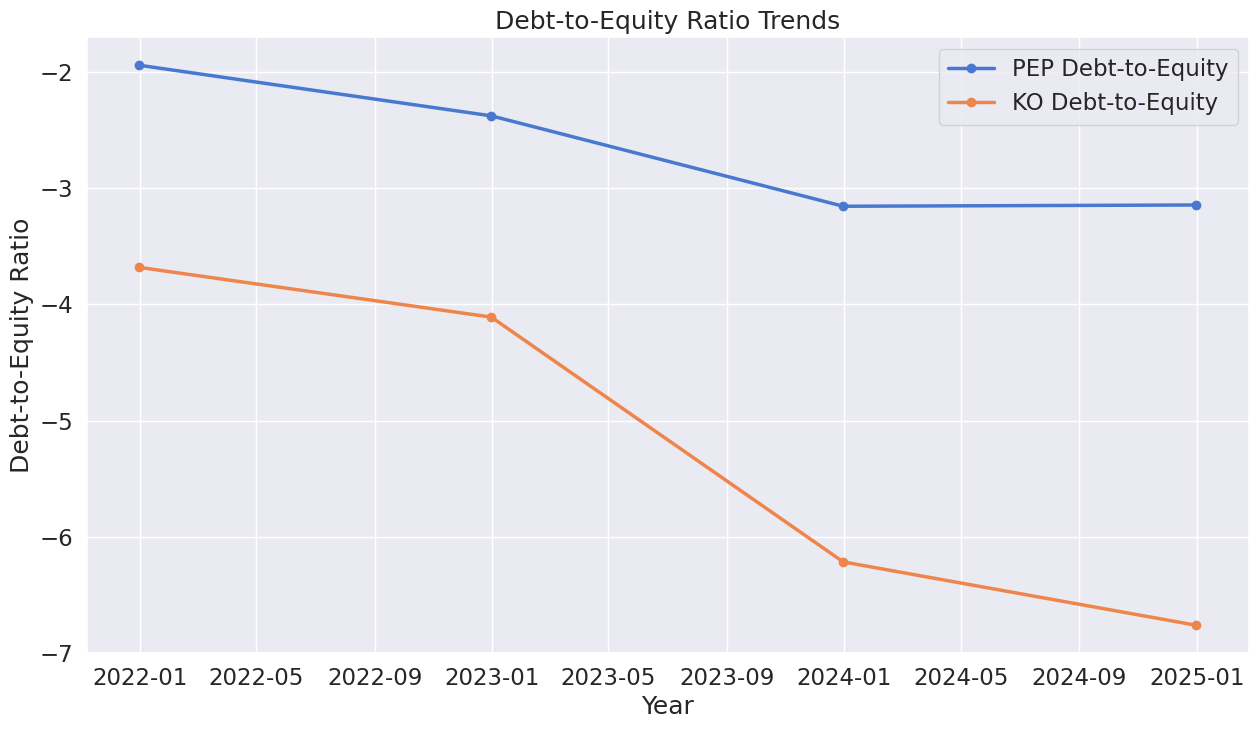

In [ ]:
# Capital Structure: Debt-to-Equity
pepsi_balance_sheet = pepsi.balance_sheet.T
coca_balance_sheet = coca_cola.balance_sheet.T

pepsi_debt_to_equity = pepsi_balance_sheet['Total Debt'] / pepsi_balance_sheet['Tangible Book Value']
coca_debt_to_equity = coca_balance_sheet['Total Debt'] / coca_balance_sheet['Tangible Book Value']

plt.figure(figsize=(15, 8))
plt.plot(pepsi_debt_to_equity, label="PEP Debt-to-Equity", marker='o')
plt.plot(coca_debt_to_equity, label="KO Debt-to-Equity", marker='o')
plt.title("Debt-to-Equity Ratio Trends")
plt.xlabel("Year")
plt.ylabel("Debt-to-Equity Ratio")
plt.legend()
#plt.grid(True)
plt.show()

### Note:

Changes & Fixes

For Available Data: Dataset does not contain "Total Liab" and "Stockholders Equity" explicitly.

Used "Total Debt" as the debt component.

Used "Tangible Book Value" as a proxy for equity (since negative values indicate shareholder deficits).

## Observations from Analysis
Revenue Trends:
- PepsiCo (PEP):
  - Steady revenue growth over the analyzed period, driven by diversified product lines (beverages and snacks).
  - Revenue is highly consistent with minimal dips.
- Coca-Cola (KO):
  - Revenue exhibits slower growth compared to PepsiCo, reflecting a stronger focus on beverages only.
  - More sensitive to shifts in consumer preferences and global beverage industry dynamics.

Profit Trends:
- PepsiCo (PEP):
  - Shows consistent profitability with a slight upward trend in net income.
  - Effective cost management and diversified operations contribute to stable profits.
- Coca-Cola (KO):
  - Volatile net income due to higher reliance on global
  beverage markets and fluctuating demand patterns.

Capital Structure:
- PepsiCo (PEP):
  - Moderate debt-to-equity ratio, indicating balanced leverage.
  - Equity-to-assets ratio signifies reliance on shareholder equity over debt
- Coca-Cola (KO):
  - Higher debt-to-equity ratio, reflecting significant reliance on debt financing.
  - Increased financial risk due to high long-term liabilities.



## Recommendations
1. For Investors:
- Consider PepsiCo (PEP) for long-term stability due to its strong diversification strategy, consistent revenue growth, and balanced capital structure.
- Coca-Cola (KO) may suit investors seeking exposure to a pure-play beverage company but should be approached with caution due to its higher leverage.

2. For Companies:
- PepsiCo: Maintain focus on product innovation and global expansion to sustain revenue growth.
- Coca-Cola: Diversify product offerings to reduce dependency on beverages and mitigate revenue volatility.

3. Capital Structure Optimization:
- Coca-Cola should consider reducing its long-term debt to enhance financial stability.
- PepsiCo’s current capital structure is well-positioned but should avoid taking on excessive debt.

## Conclusion

The fundamental analysis reveals that PepsiCo outperforms Coca-Cola in terms of revenue consistency, profitability, and balanced capital structure. While Coca-Cola’s performance is notable, its reliance on debt financing and narrower product focus create greater financial risk.
Overall Recommendation: PepsiCo (PEP) is the better investment option for long-term stability, while Coca-Cola (KO) may appeal to investors with a higher risk tolerance seeking exposure to the beverage industry.
If you’d like to explore specific areas further, such as cash flow analysis or sector comparisons, let me know!

Output: Insights
Historical Trends:

Visualized pricing trends and returns highlight stock movements.

Daily returns and historical volatility provide insights into risk levels.

Sector Impacts and Financial Health:

Scatter plots show how stocks compare in terms of risk and reward.

Comparison Against Index:

Line charts highlight relative performance compared to a market index.

Investment Recommendations:

Volatility vs Returns visualizations highlight suitability for investment based on client needs.

## Modeling
### XGBoost Model



### LSTM Model

### Key Insights:
XGBoost:

Better for tabular data with structured patterns.

Lightweight and interpretable.

LSTM:

Ideal for sequential or time-series data.

Captures temporal dependencies well but requires more computational resources.